# Poisson HMM on example session

In [7]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
import seaborn as sns
from collections import defaultdict
import pandas as pd

from one.api import ONE
from jax import vmap
from pprint import pprint
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from dynamax.hidden_markov_model import PoissonHMM


# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//2_fit_models/'
#functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files, prepro_design_matrix, concatenate_sessions, fix_discontinuities
from fitting_functions import cross_validate_poismodel
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//3_postprocess_results/'
#functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from plotting_functions import plot_transition_mat, plot_states_aligned, params_to_df, align_bin_design_matrix, states_per_trial_phase, plot_states_aligned_trial, traces_over_sates, traces_over_few_sates
from postprocessing_functions import best__kappa
one = ONE()

## Parameters

In [2]:
bin_size = 0.1
# bin_size = 0.02

# Plotting params
multiplier = 1/bin_size

event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'


# Load data

In [3]:
# Load preprocessed data
prepro_results_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/'
os.chdir(prepro_results_path)
idxs, mouse_names, matrix_all, matrix_all_unnorm, session_all = pickle.load(open(prepro_results_path + "preprocessed_data_v4_170724", "rb"))

## Concatenate sessions of the same animal

In [4]:
collapsed_matrices, collapsed_unnorm, collapsed_trials = concatenate_sessions (mouse_names, matrix_all, matrix_all_unnorm, session_all)

## Parameters

In [9]:
num_iters = 100
num_train_batches = 5
method = 'kmeans'
threshold = 0.05

num_lags = 5  # First order ARHMM
num_states = 2
kappa = 100

# use_vars = ['avg_wheel_vel', 'Lick count', 'whisker_me',
#        'left_X', 'left_Y', 'right_X', 'right_Y', 'nose_X', 'nose_Y']
use_sets = [['avg_wheel_vel'], ['Lick count'], ['whisker_me'],
            ['left_X', 'left_Y', 'right_X', 'right_Y'], ['nose_X', 'nose_Y']]
var_interest_map = ['avg_wheel_vel', 'Lick count', 'whisker_me', 'left_X', 'nose_X']
idx_init_list = [0, 1, 2, 3, 7]
idx_end_list = [1, 2, 3, 7, 9]

var_interest = 'Lick count'

sticky = False
# Values for grid search (should get this from results)
last_lag = 20
lag_step = 2
start_lag = 1
Lags = list(range(start_lag, last_lag, lag_step))
if sticky:
    kappas = [1, 5, 10, 100, 500, 1000, 2000, 5000, 7000, 10000]
else:
    kappas = [0, 1, 5, 10, 100, 500, 1000, 2000, 5000, 7000, 10000]

## Concatenate sessions of the same animal

In [10]:
collapsed_matrices, collapsed_unnorm, collapsed_trials = concatenate_sessions (mouse_names, matrix_all, matrix_all_unnorm, session_all)

d839491f-55d8-4cbe-a298-7839208ba12b_CSHL049


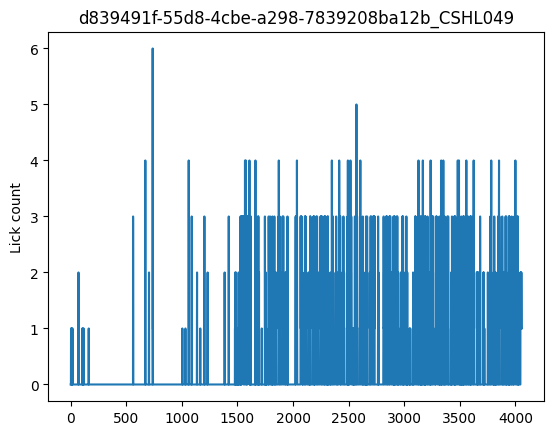

28741f91-c837-4147-939e-918d38d849f2_CSHL058


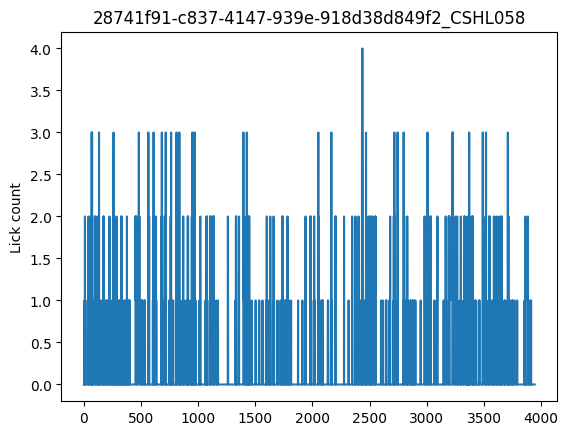

fb70ebf7-8175-42b0-9b7a-7c6e8612226e_CSHL058


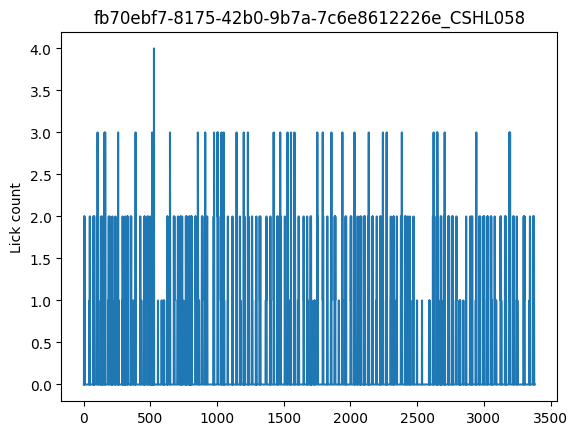

46794e05-3f6a-4d35-afb3-9165091a5a74_CSHL045


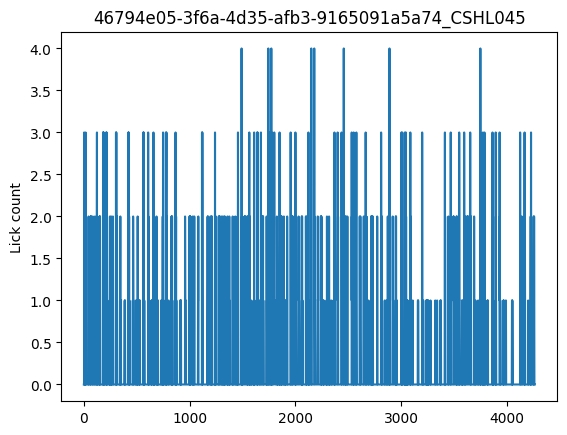

bda2faf5-9563-4940-a80f-ce444259e47b_UCLA037


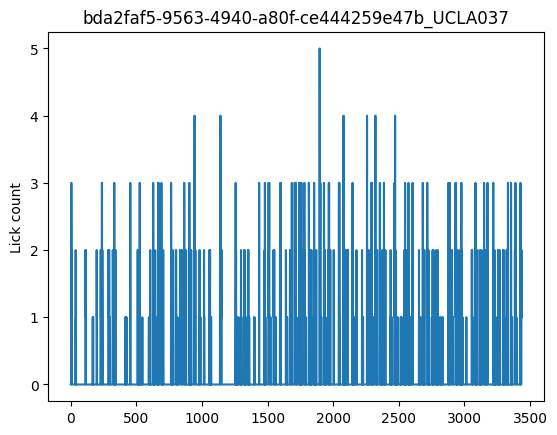

7939711b-8b4d-4251-b698-b97c1eaa846e_CSHL045


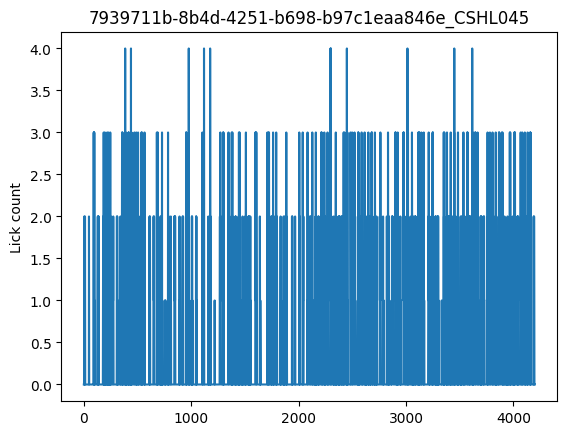

111c1762-7908-47e0-9f40-2f2ee55b6505_UCLA033


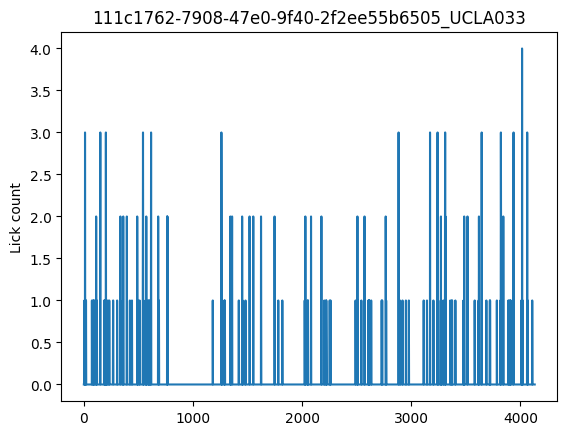

37e96d0b-5b4b-4c6e-9b29-7edbdc94bbd0_CSHL059


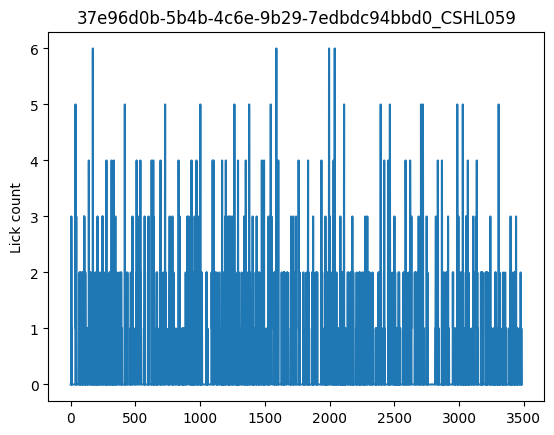

fa704052-147e-46f6-b190-a65b837e605e_CSHL045


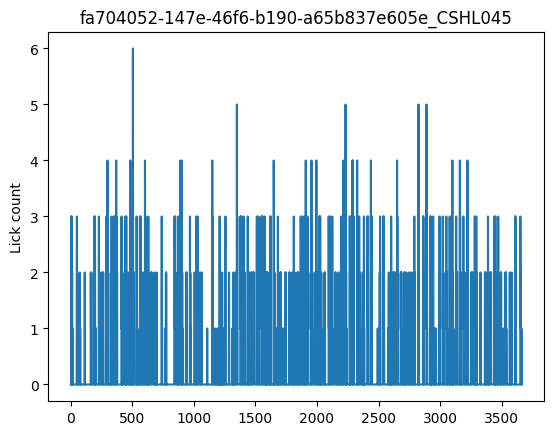

1f095590-6669-46c9-986b-ccaf0620c5e9_UCLA012


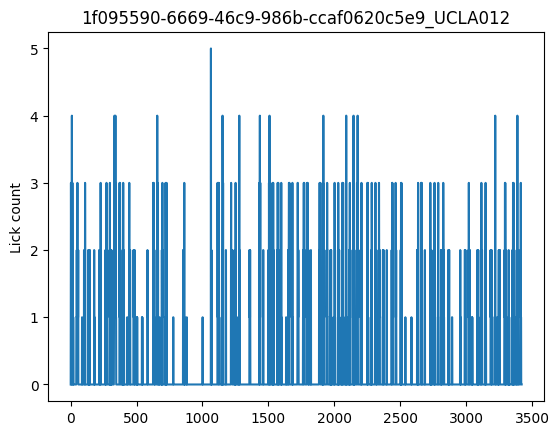

a71175be-d1fd-47a3-aa93-b830ea3634a1_CSHL054


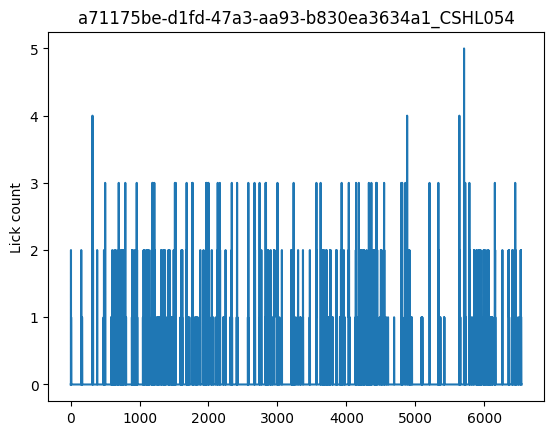

ecb5520d-1358-434c-95ec-93687ecd1396_CSHL051


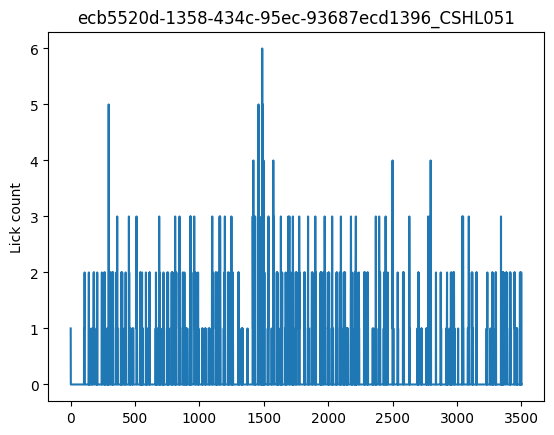

7be8fec4-406b-4e74-8548-d2885dcc3d5e_CSHL060


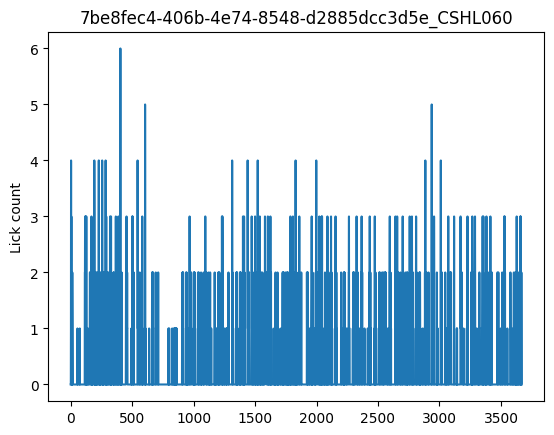

16693458-0801-4d35-a3f1-9115c7e5acfd_KS014


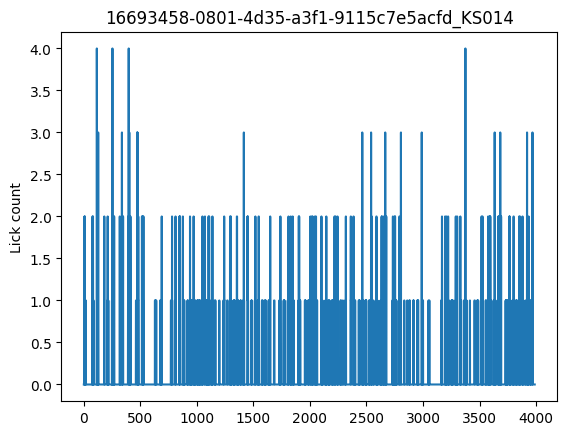

1191f865-b10a-45c8-9c48-24a980fd9402_CSHL060


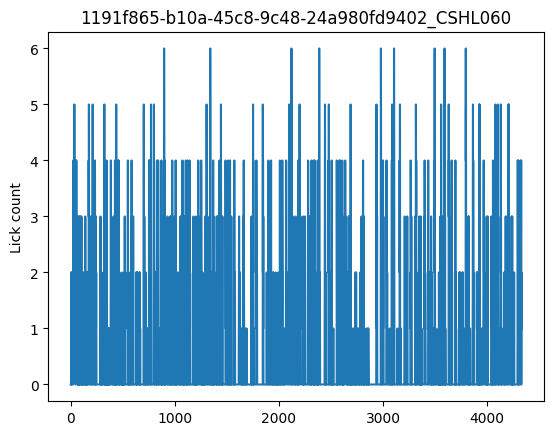

e1931de1-cf7b-49af-af33-2ade15e8abe7_KS014


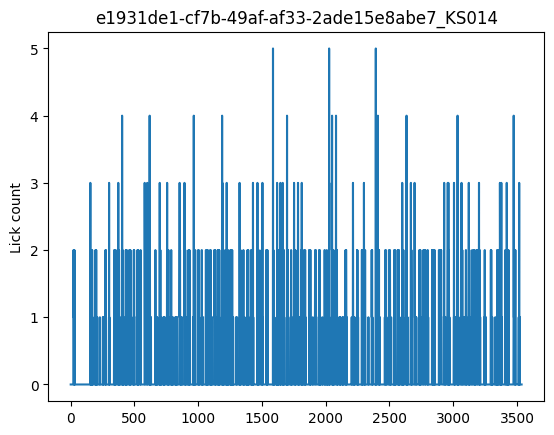

8d316998-28c3-4265-b029-e2ca82375b2f_UCLA037


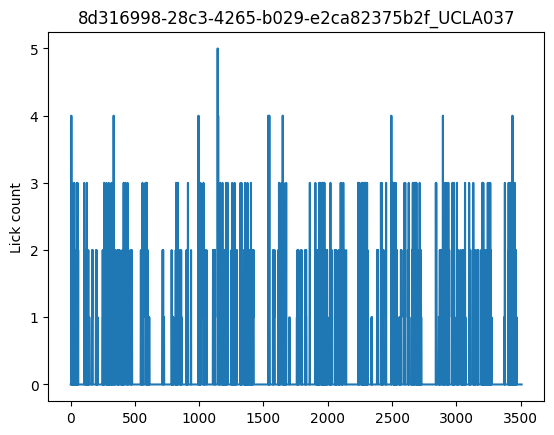

2d5f6d81-38c4-4bdc-ac3c-302ea4d5f46e_CSHL047


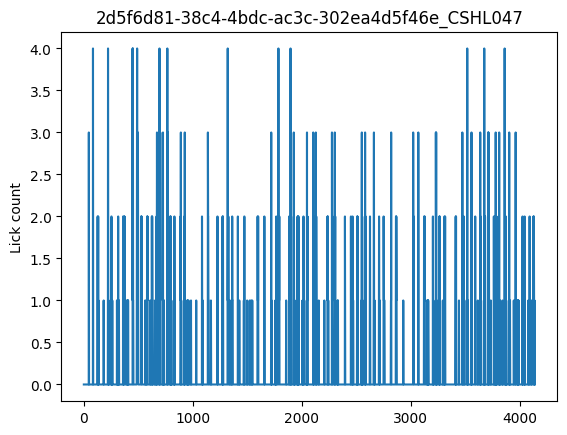

537677fe-1e24-4755-948c-fa4a4e8ecce5_NYU-45


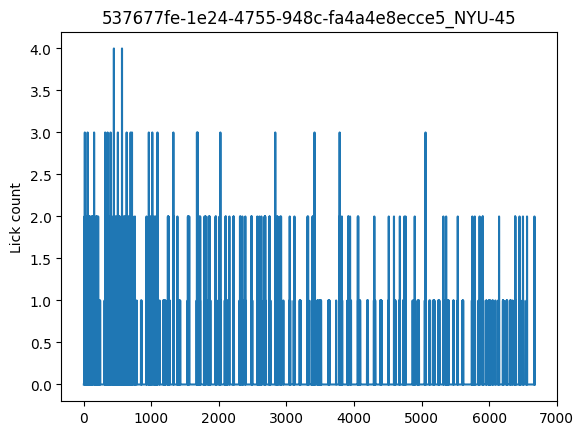

dfd8e7df-dc51-4589-b6ca-7baccfeb94b4_CSHL045


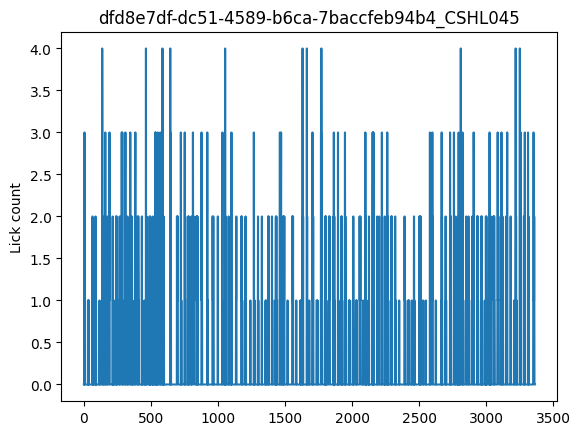

f10efe41-0dc0-44d0-8f26-5ff68dca23e9_CSHL060


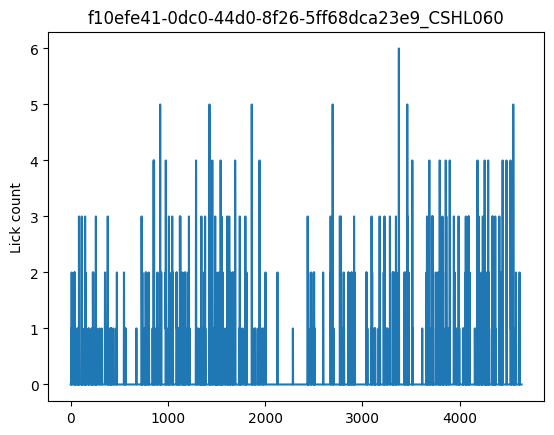

57b5ae8f-d446-4161-b439-b191c5e3e77b_CSHL059


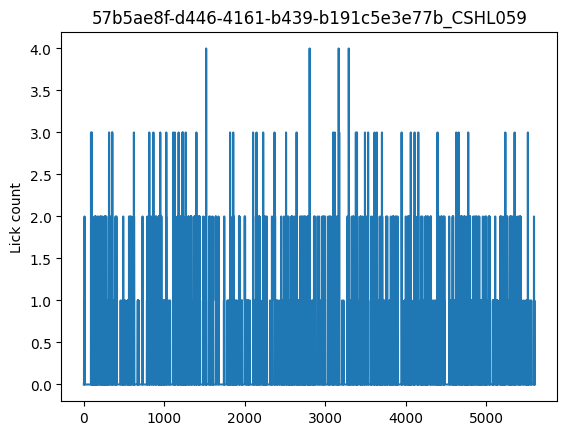

3663d82b-f197-4e8b-b299-7b803a155b84_CSHL052


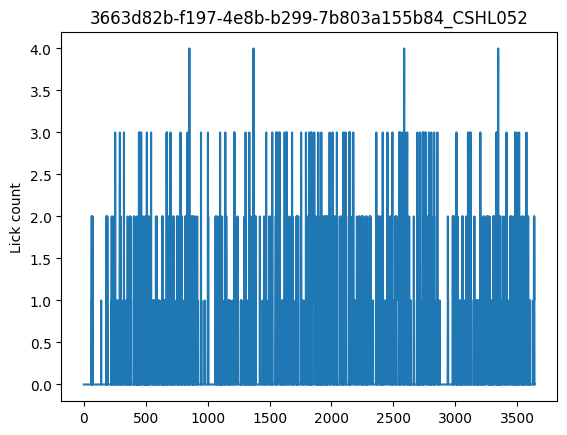

dda5fc59-f09a-4256-9fb5-66c67667a466_CSHL059


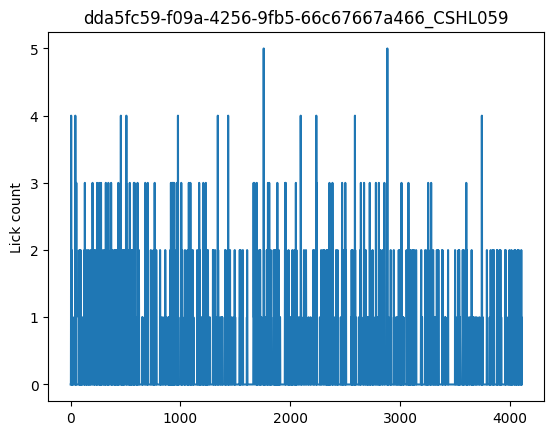

ebc9392c-1ecb-4b4b-a545-4e3d70d23611_UCLA034


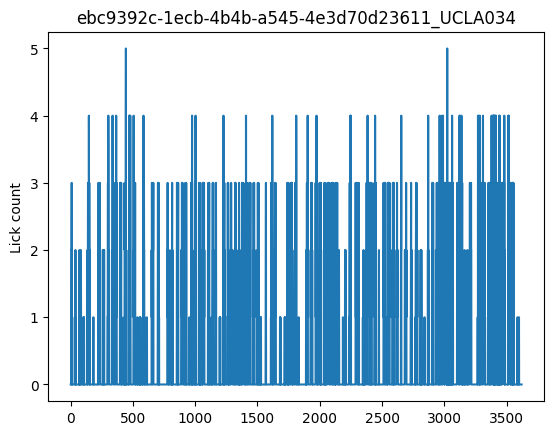

b52182e7-39f6-4914-9717-136db589706e_CSHL047


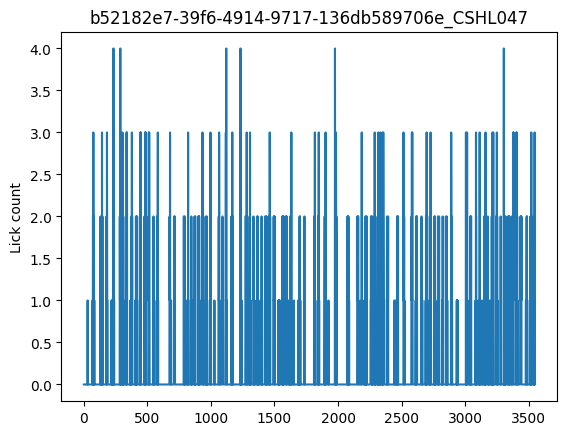

c99d53e6-c317-4c53-99ba-070b26673ac4_CSHL049


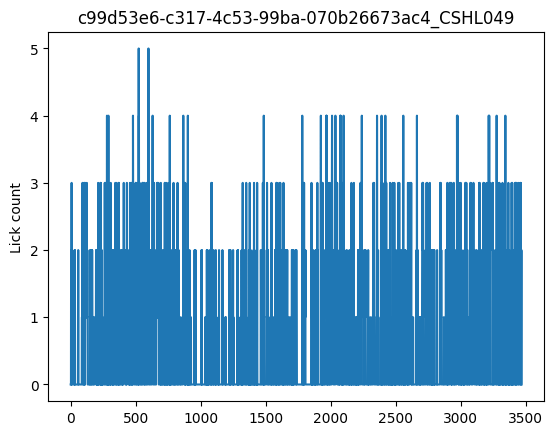

f312aaec-3b6f-44b3-86b4-3a0c119c0438_CSHL058


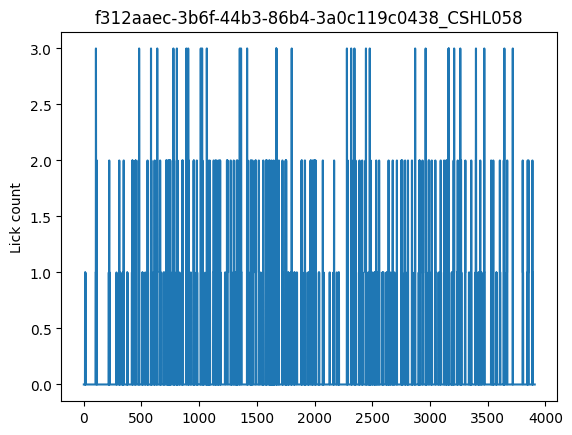

d16a9a8d-5f42-4b49-ba58-1746f807fcc1_CSHL059


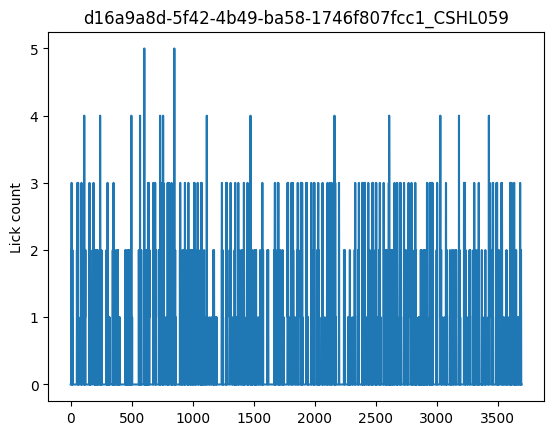

32d27583-56aa-4510-bc03-669036edad20_UCLA033


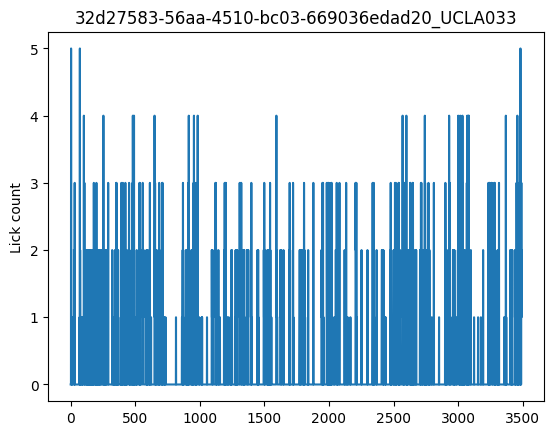

2e6e179c-fccc-4e8f-9448-ce5b6858a183_CSHL060


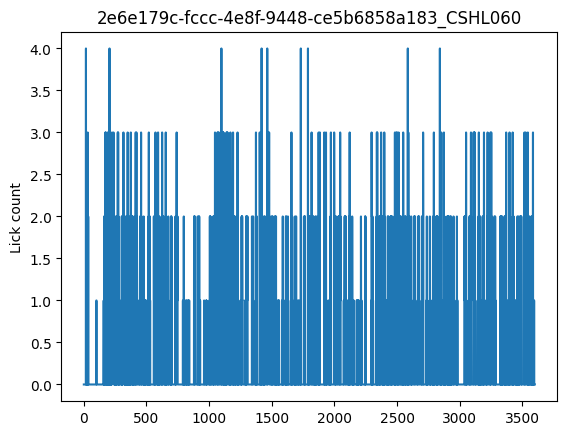

f99ac31f-171b-4208-a55d-5644c0ad51c3_UCLA035


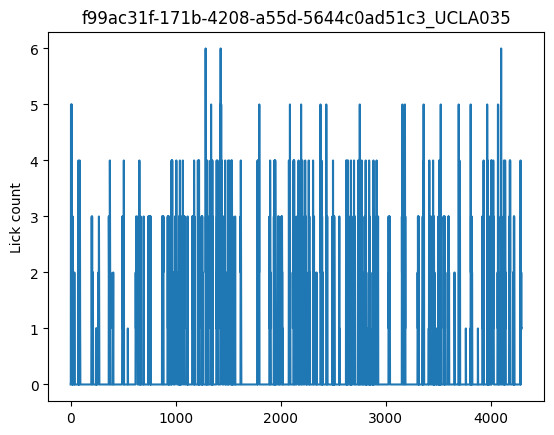

In [5]:
for m, mat in enumerate(idxs):
    if len(mat) > 35: 
        
        mouse_name = mat[37:]
        # mouse_name = 'CSHL060'
        session = mat[0:36]
        
        # Get mouse data
        session_trials = session_all[mouse_name][session]
        design_matrix = matrix_all[mouse_name][session]
        unnorm_mat = matrix_all_unnorm[mouse_name][session]  
        
        if len(np.shape(design_matrix)) > 2:
            design_matrix = design_matrix[0]
            session_trials = session_trials[0]
            unnorm_mat = matrix_all_unnorm[mouse_name][0]
        
        plt.plot(unnorm_mat['Lick count'])
        print(mat)
        plt.ylabel('Lick count')
        plt.title(mat)
        plt.show()


## Parameters

In [11]:
num_iters = 100
num_train_batches = 5
method = 'kmeans'
threshold = 0.05

num_states = 2
kappa = 0


/tmp/ipykernel_65578/1903062713.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin']


2


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:501: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


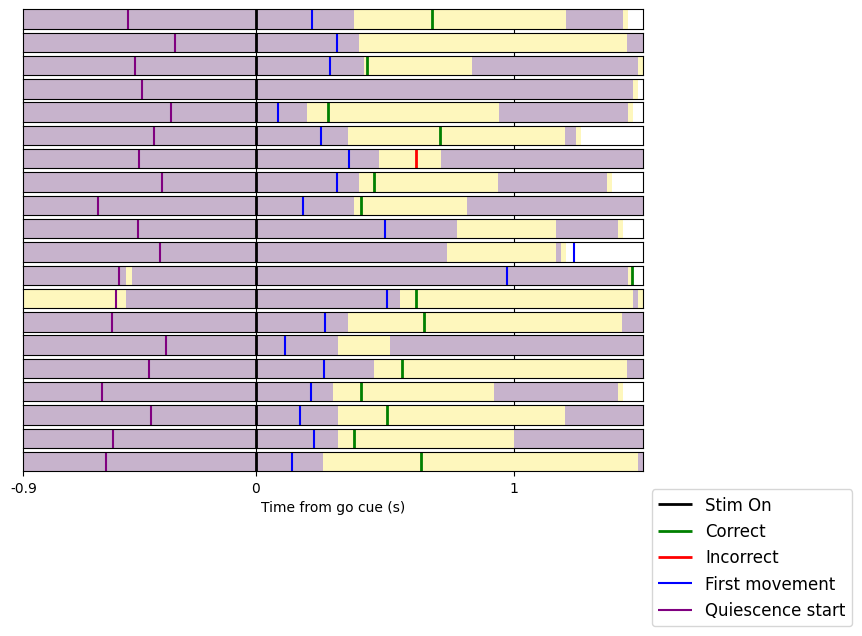

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


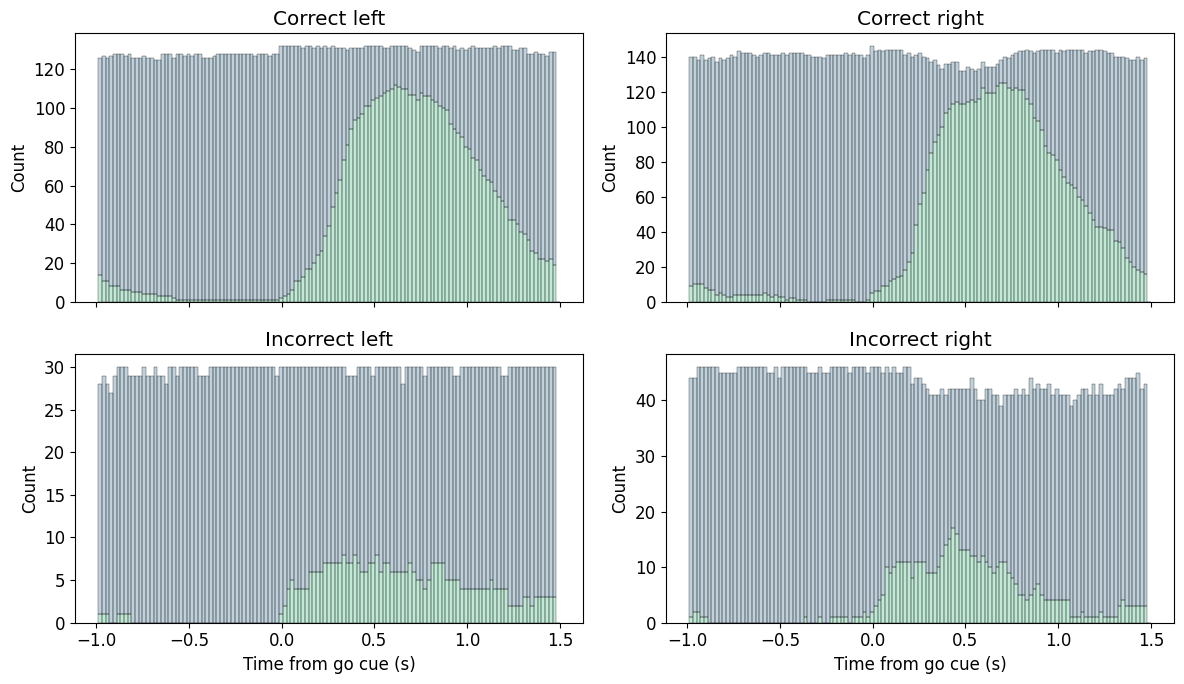

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:279: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:280: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:281: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plot

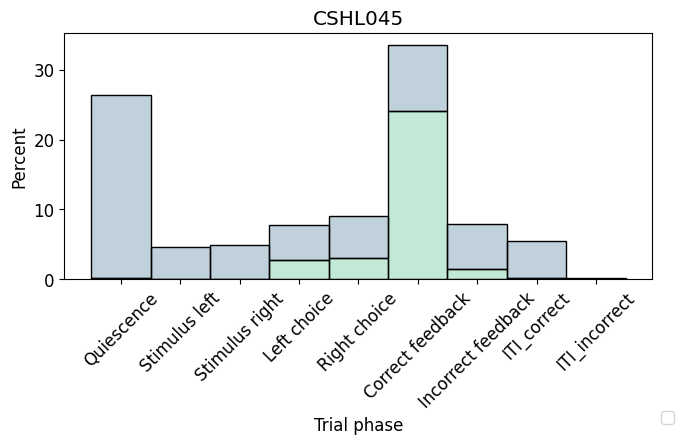

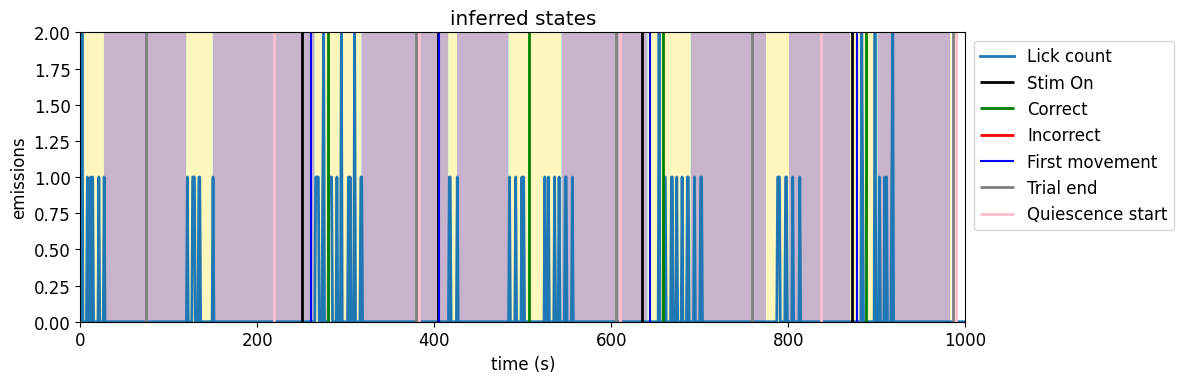

/tmp/ipykernel_65578/1903062713.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin']


3


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:501: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


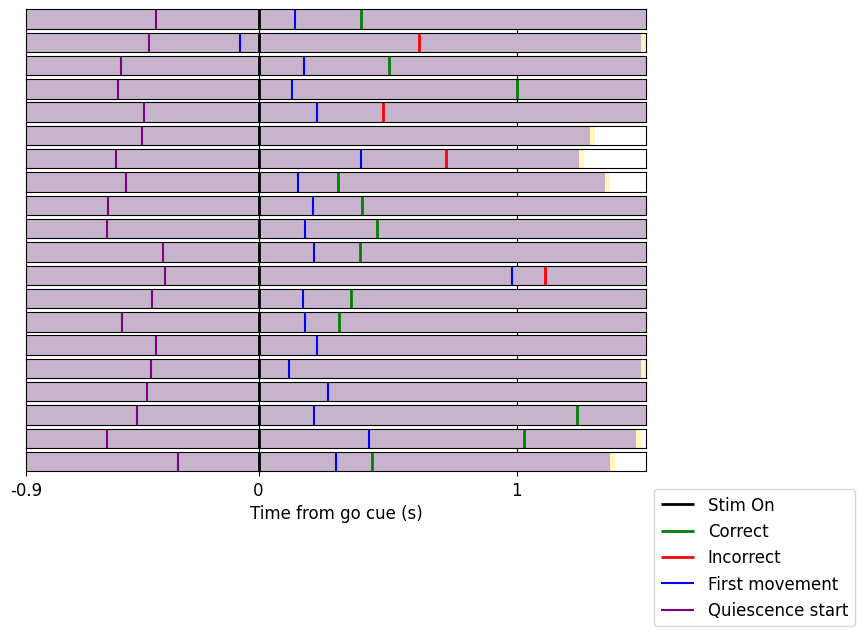

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


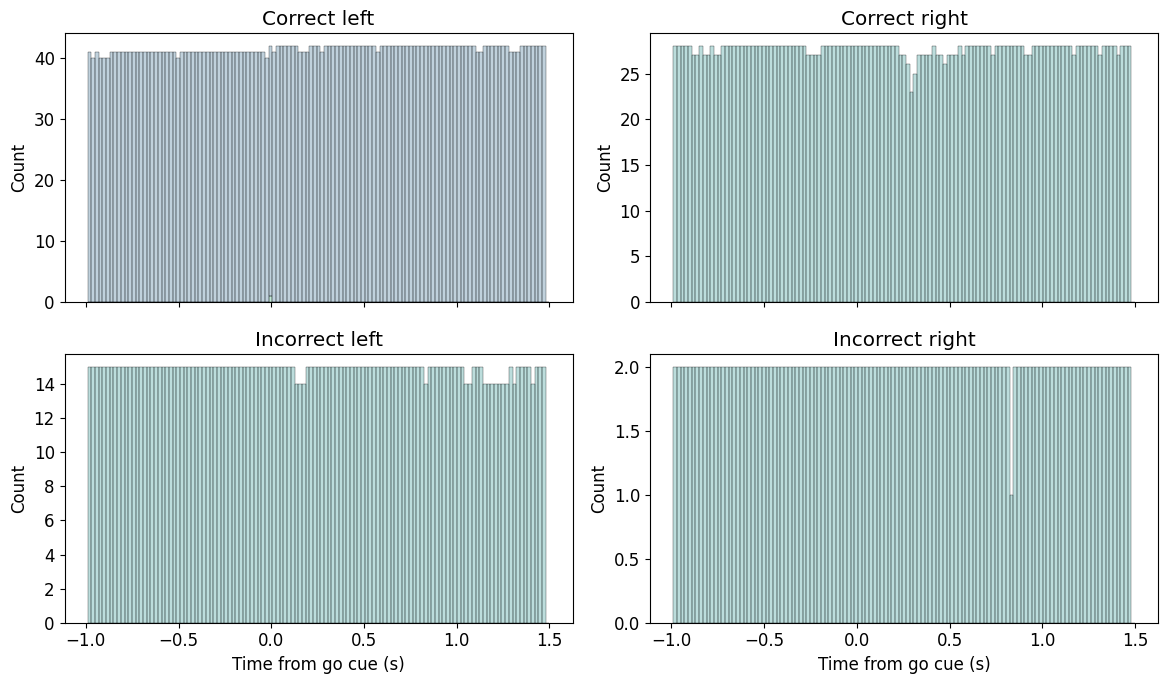

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:279: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:280: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:281: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plot

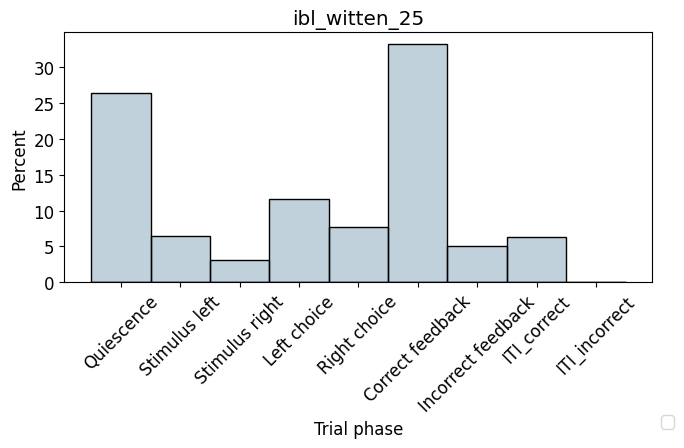

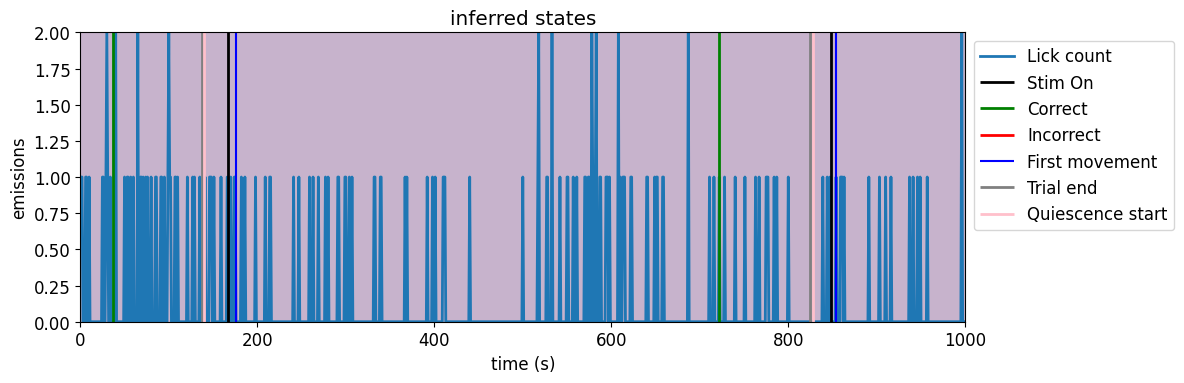

/tmp/ipykernel_65578/1903062713.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin']


4


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:501: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


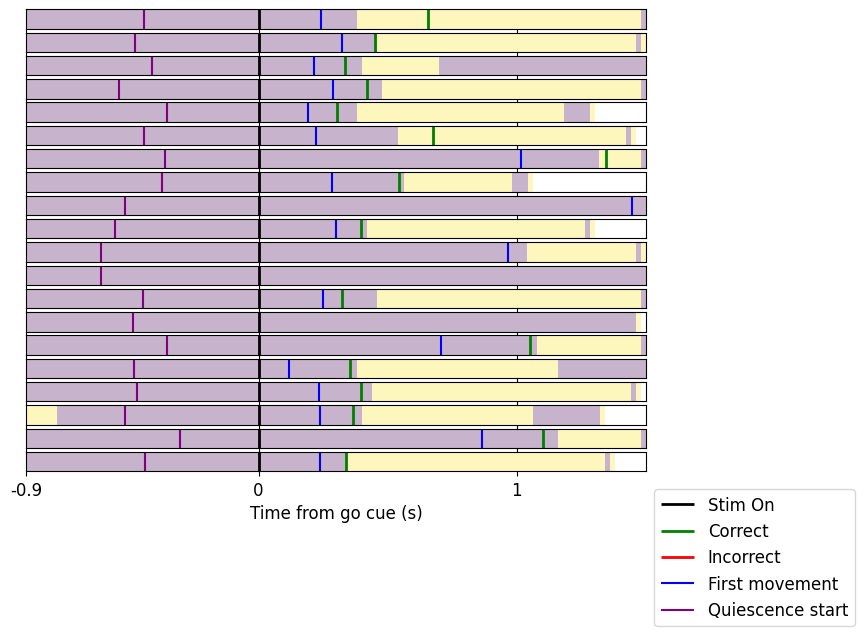

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


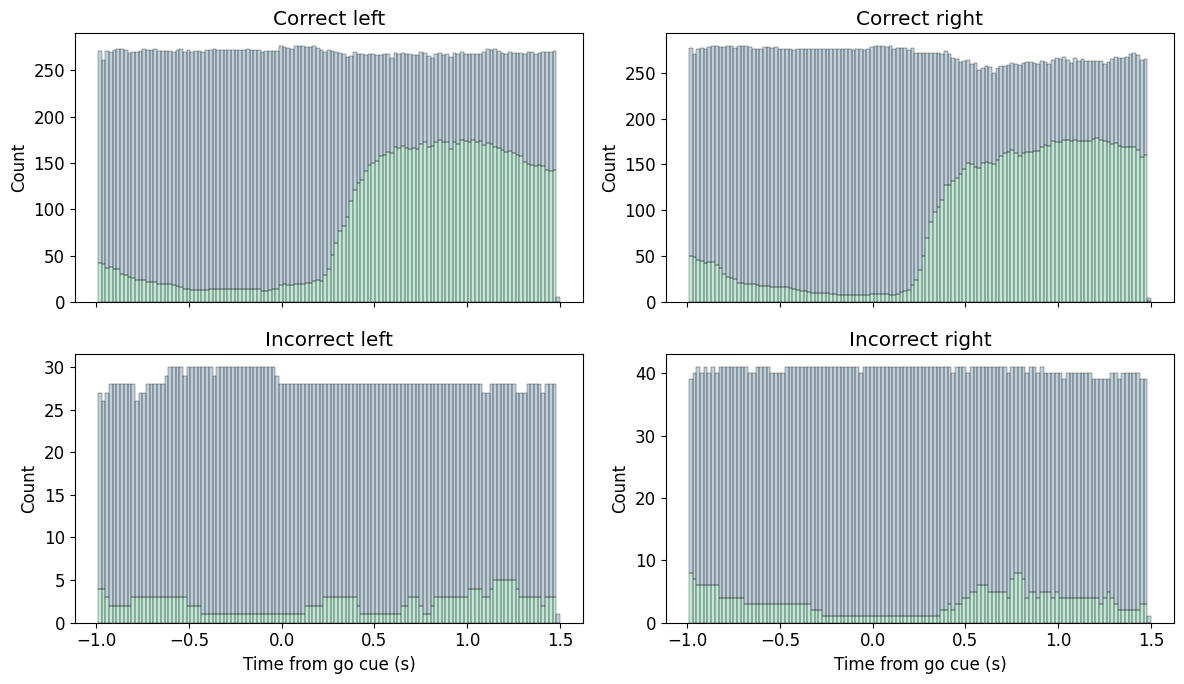

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:279: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:280: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:281: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plot

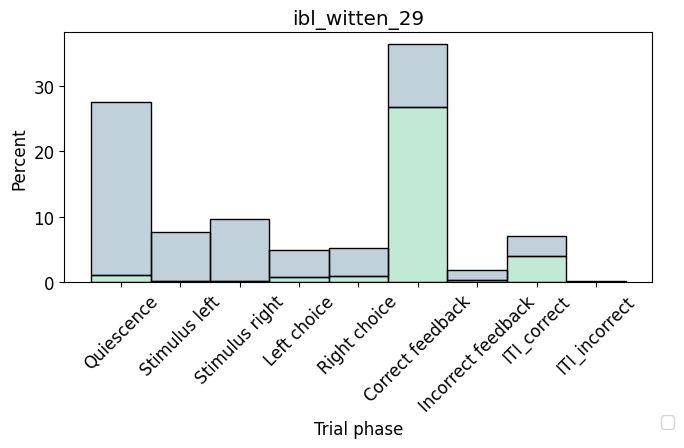

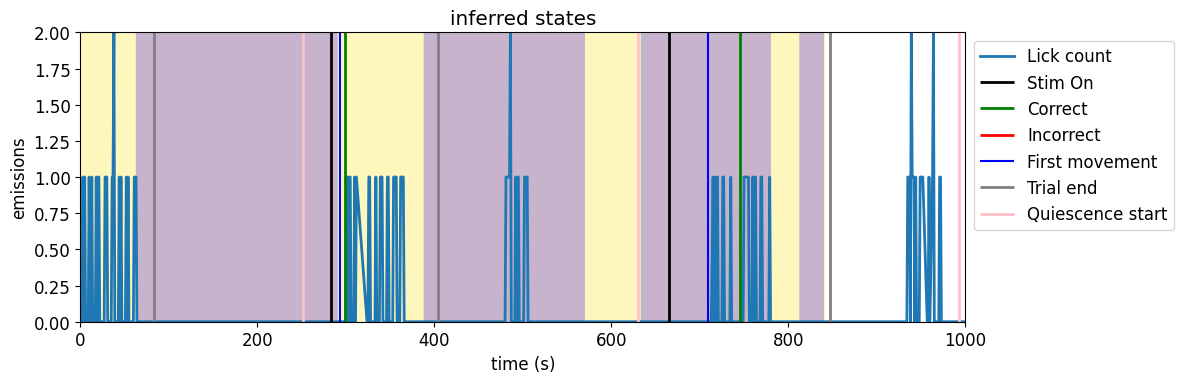

/tmp/ipykernel_65578/1903062713.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin']


4


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:501: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


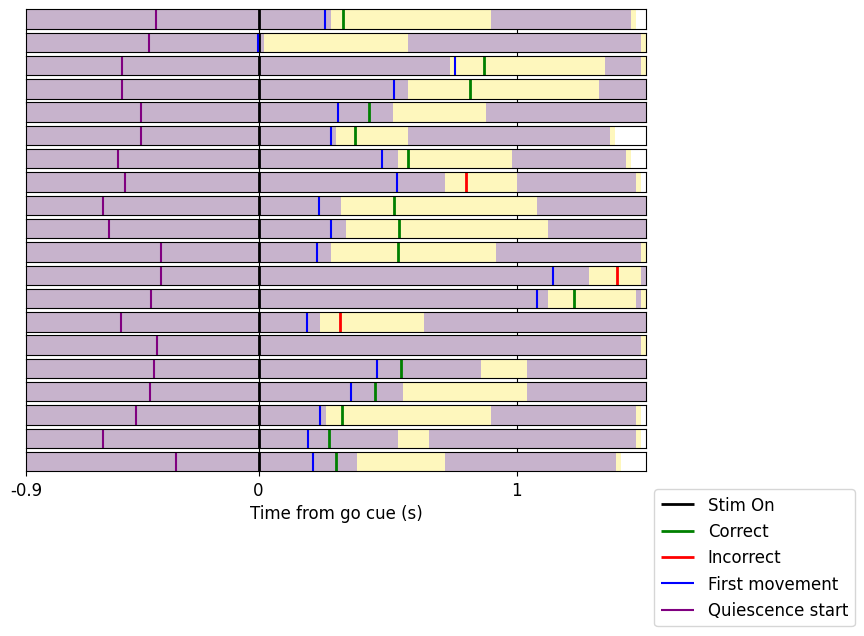

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


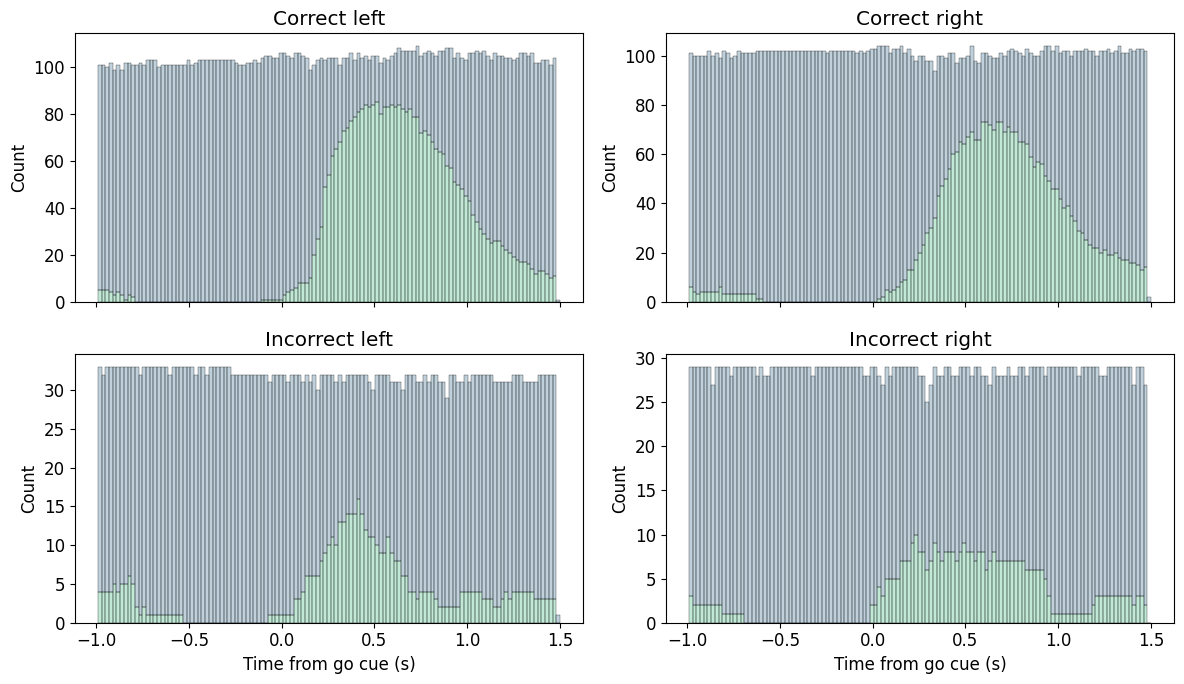

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:279: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:280: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:281: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plot

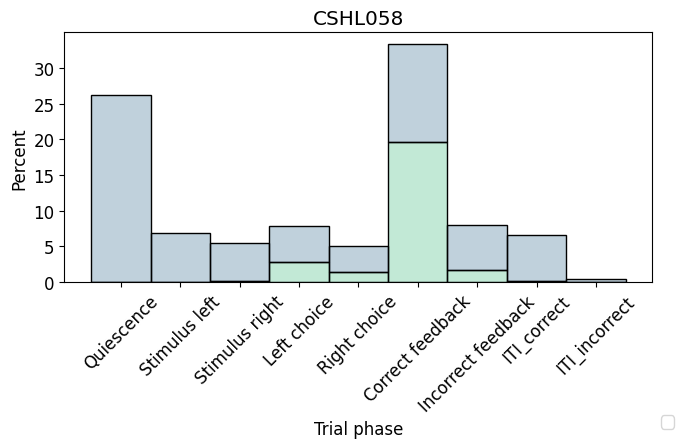

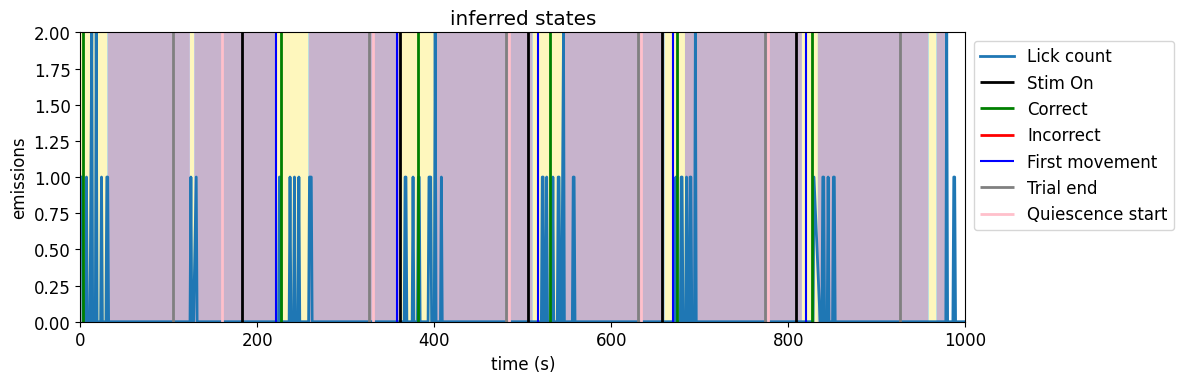

/tmp/ipykernel_65578/1903062713.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin']


4


KeyboardInterrupt: 

In [9]:
for m, mouse_name in enumerate(mouse_names):
    
    index_var = np.where(np.array(var_interest_map)==var_interest)[0][0]
    idx_init = idx_init_list[index_var]
    idx_end = idx_end_list[index_var]
    var_names = use_sets[index_var]
    
    # Get mouse data
    session_trials = collapsed_trials[mouse_name]
    design_matrix = collapsed_matrices[mouse_name][:,idx_init:idx_end]
    unnorm_mat = collapsed_unnorm[mouse_name][var_names]
    unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin']

    " Fit model with cross-validation"
    # Prepare data for cross-validation
    num_timesteps = np.shape(design_matrix)[0]
    emission_dim = np.shape(design_matrix)[1]
    shortened_array = np.array(design_matrix[:(num_timesteps // num_train_batches) * num_train_batches])
    train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))

    # Initialize model with Kmeans
    test_phmm = PoissonHMM(num_states, emission_dim, transition_matrix_stickiness=kappa)
    init_params, props = test_phmm.initialize(key=jr.PRNGKey(1))  # for now all data
    
    # Fit model to all data with cross-validation
    val_lls, fit_params, init_params, baseline_lls = cross_validate_poismodel(test_phmm, 
                                                                            jr.PRNGKey(0), shortened_array, 
                                                                            train_emissions, num_train_batches)
    " Re-fit with parameters of best fold "
    # Find best fold
    use_fold = np.where(val_lls==np.nanmax(val_lls))[0][0]
    print(use_fold)
    
    # Find parameters for best fold
    initial_probs = fit_params[0].probs[use_fold]
    transition_matrix = fit_params[1].transition_matrix[use_fold]
    emission_rates = fit_params[2].rates[use_fold]     
    
    # Initialize new hmm
    new_bhmm = PoissonHMM(num_states, emission_dim)
    best_fold_params, props = new_bhmm.initialize(key=jr.PRNGKey(0), method=method,
                                    initial_probs=initial_probs,
                                    transition_matrix=transition_matrix,               
                                    emission_rates=emission_rates) 
    
    # Get state estimates for validation data
    most_likely_states = new_bhmm.most_likely_states(best_fold_params, shortened_array)

    # Keep only enough states to explain 95% observations
    unique, counts = np.unique(most_likely_states, return_counts=True)
    threshold_count = threshold * len(most_likely_states)
    excluded_bins = 0
    remaining_states = list(counts.copy())
    for state in unique:
        size_smallest_state = np.nanmin(remaining_states)
        if size_smallest_state + excluded_bins < threshold_count:
            remaining_states[np.where(counts==size_smallest_state)[0][0]] = np.nan
            excluded_bins += size_smallest_state
    
    # Remove states below threshold
    new_states = np.array(most_likely_states).astype(float)
    exclude_states = np.where(np.isnan(np.array(remaining_states)))[0].astype(float)
    # Create a boolean mask to identify values to replace
    mask = np.isin(new_states, exclude_states)
    # Replace values in main_array with np.nan using the boolean mask
    new_states[mask] = np.nan
    new_states = most_likely_states
    
    # Prepare data
    design_matrix_heading = pd.DataFrame(columns=var_names)
    design_matrix_heading[var_names] = design_matrix[0:len(most_likely_states)]  # TODO: need to understand why number is the same and whether it depends on lag
    bins = unnorm_mat[:(num_timesteps // num_train_batches) * num_train_batches]['Bin']
    design_matrix_heading['Bin'] = bins
    
    # Fix discontinuities
    cont_trials, cont_design_matrix_heading = fix_discontinuities(session_trials, design_matrix_heading, multiplier)

    # Align bins
    init = -1 * multiplier
    end = 1.5 * multiplier
    empirical_data = align_bin_design_matrix(init, end, event_type_list, cont_trials, cont_design_matrix_heading, new_states, multiplier)

    """ Stack trial states """
    trial_init = 30  # First trial to plot
    trials_to_plot = 20  # How many trials to plot (if very different will compromise readibility)
    plot_states_aligned_trial(trial_init, empirical_data, cont_trials, bin_size, trials_to_plot, num_states)

    " Plot states stacked and aligned per trial type "
    plot_states_aligned(init, end, empirical_data, event_type_name, bin_size)
    
    """ Plot states per trial epoch """
    colors = sns.color_palette("viridis", num_states)
    # states_trial = states_per_trial_phase(empirical_data, session_trials, multiplier)
    states_trial = states_per_trial_phase(empirical_data, cont_trials, multiplier)

    plt.figure(figsize=[7, 5])
    sns.histplot(x='label', hue=0, data=states_trial, stat = 'percent',
                        multiple="stack", legend=True, palette='viridis', alpha=0.3)  # stat='frequency',
    plt.xlabel('Trial phase')
    plt.legend(loc='upper left', bbox_to_anchor=(1, -0.5))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.title(mouse_name)
    plt.show()

    """ Plot raw traces over states """
    init = 250*multiplier # First bin
    inter = 20*multiplier
    # traces_over_few_sates(init, empirical_data, session_trials, var_names)
    traces_over_few_sates(init, inter, empirical_data, cont_trials, var_names, multiplier)
    

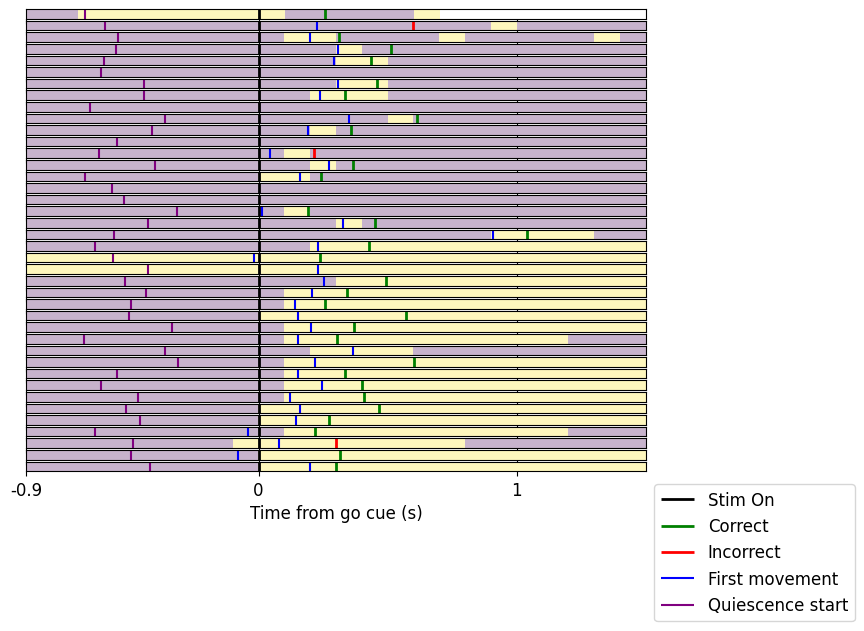

In [52]:
""" Stack trial states """
trial_init = 0  # First trial to plot
trials_to_plot = 40  # How many trials to plot (if very different will compromise readibility)
plot_states_aligned_trial(trial_init, empirical_data, session_trials, bin_size, trials_to_plot, num_states)


## Fit best params

In [18]:
filename in files

False

/tmp/ipykernel_69827/3611115062.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:452: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


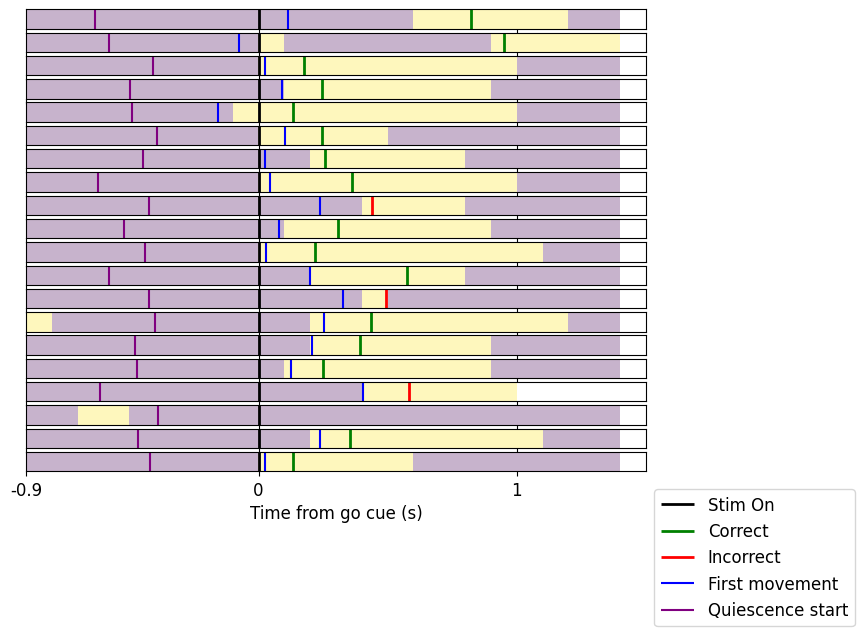

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


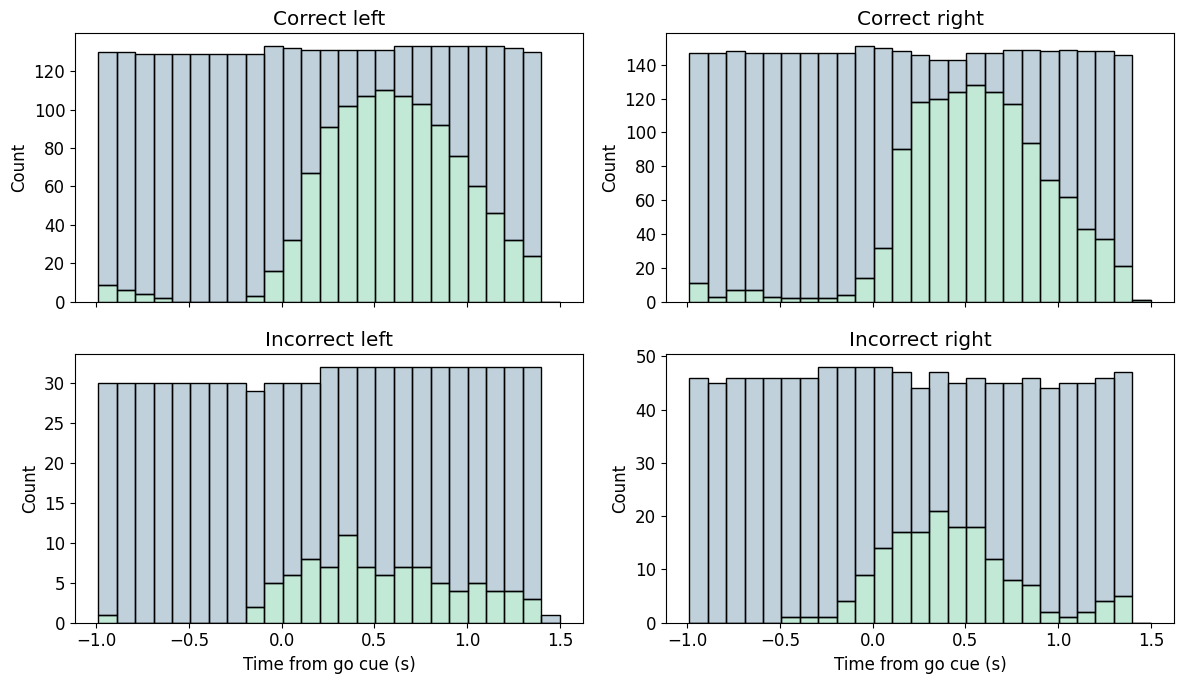

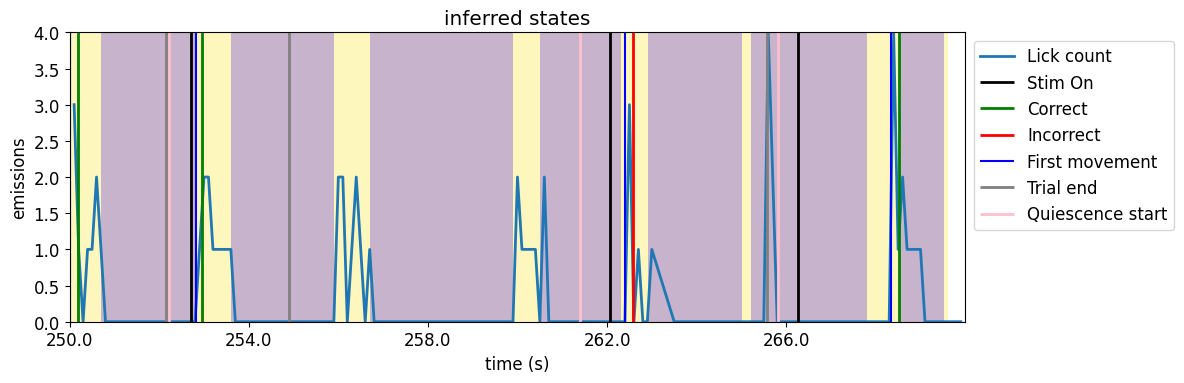

/tmp/ipykernel_69827/3611115062.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:452: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/matplotlib/axes/_base.py:2480: UserWarning: Warning: converting a masked element to 

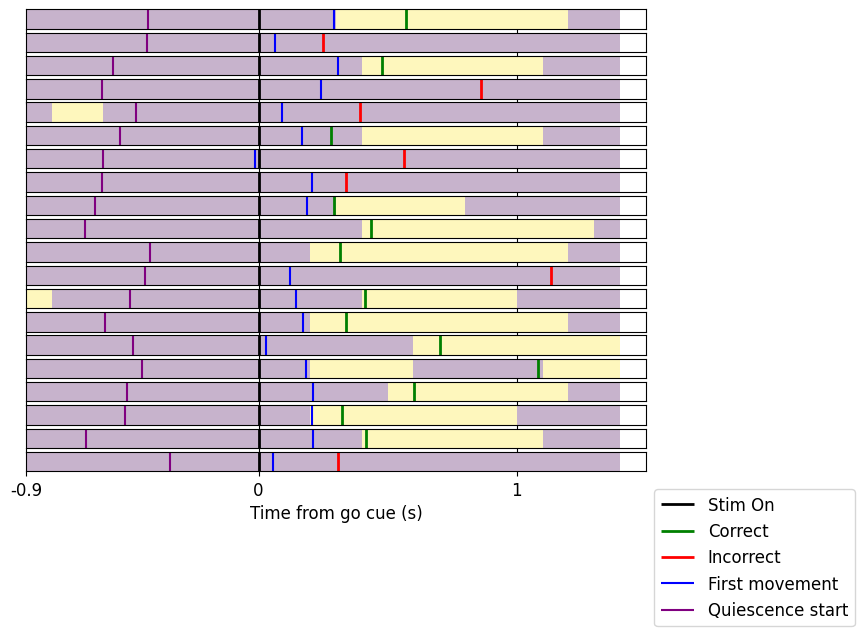

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


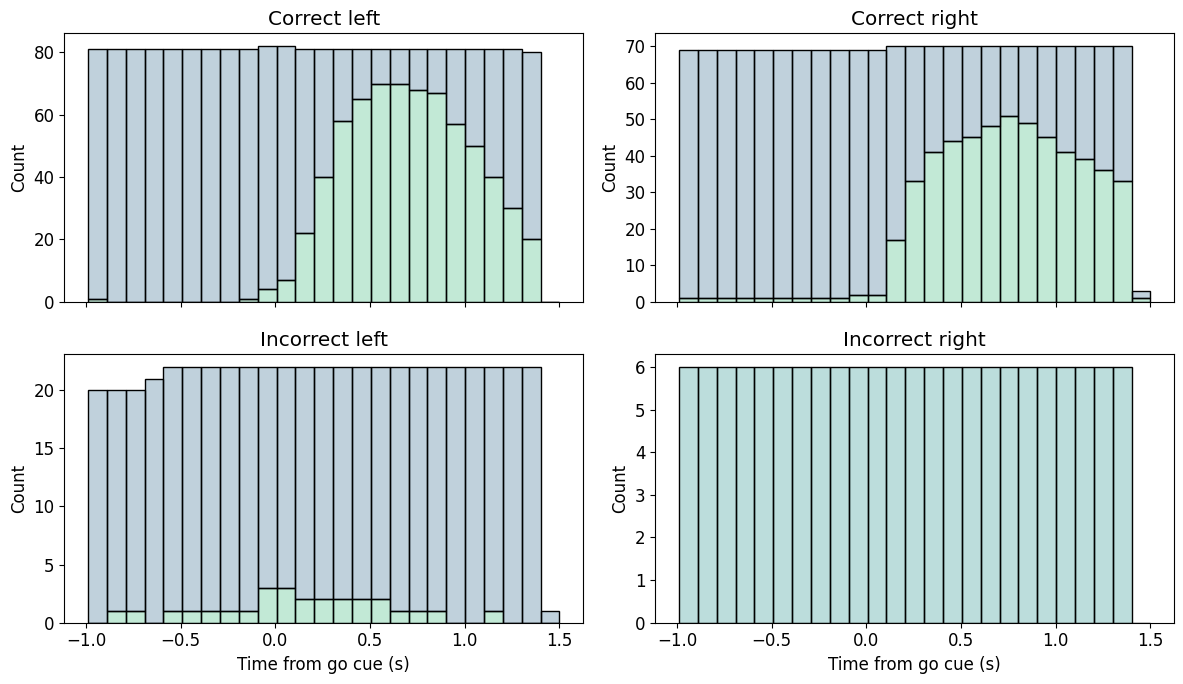

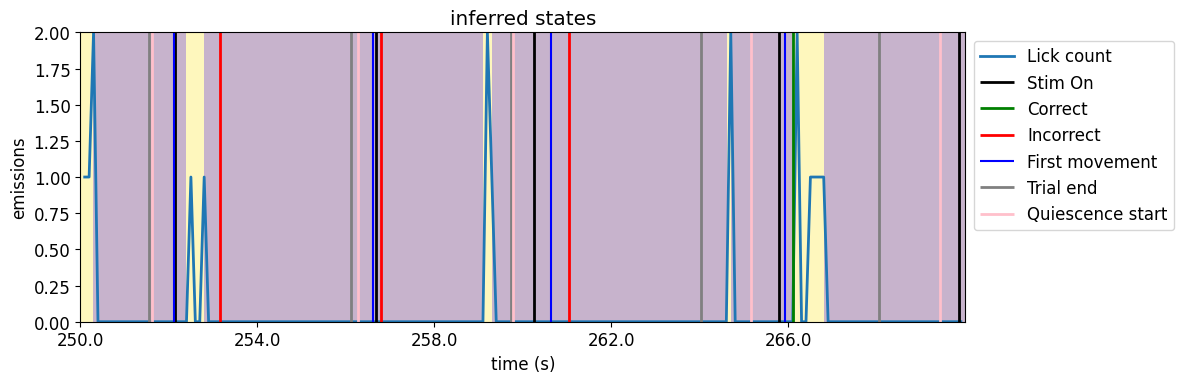

/tmp/ipykernel_69827/3611115062.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:452: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


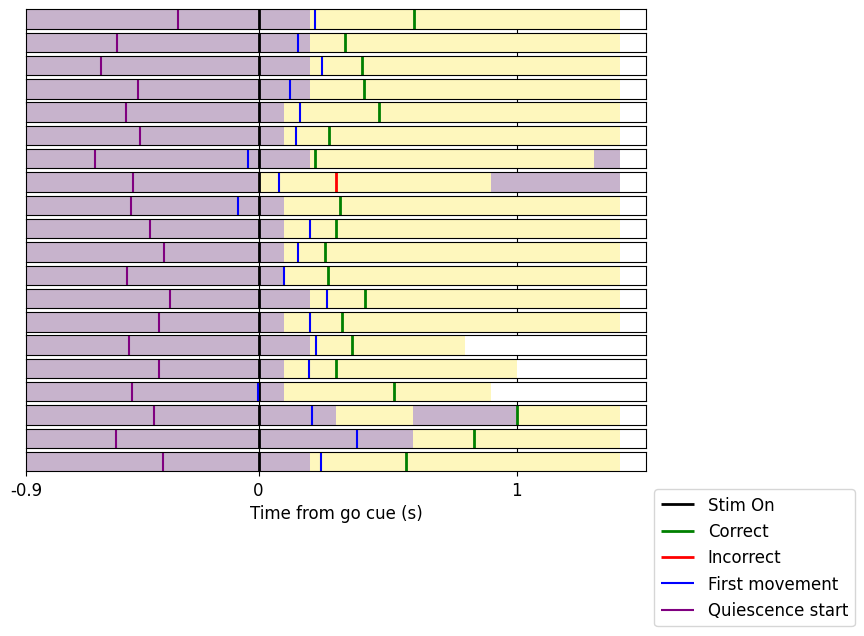

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


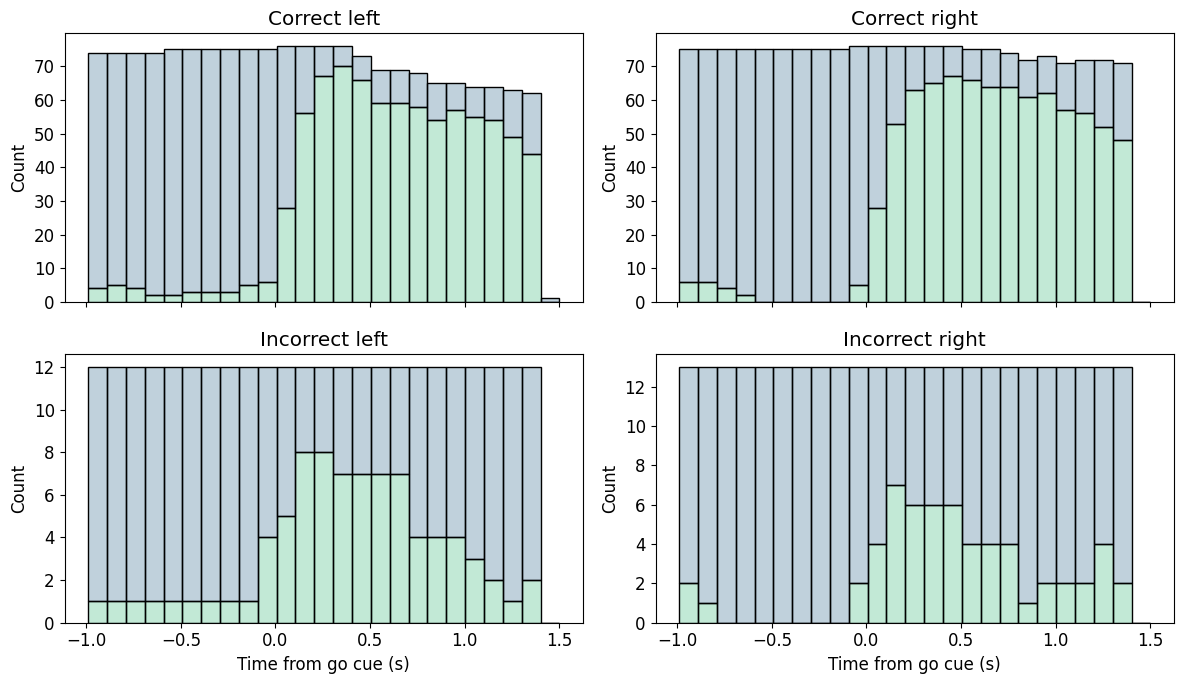

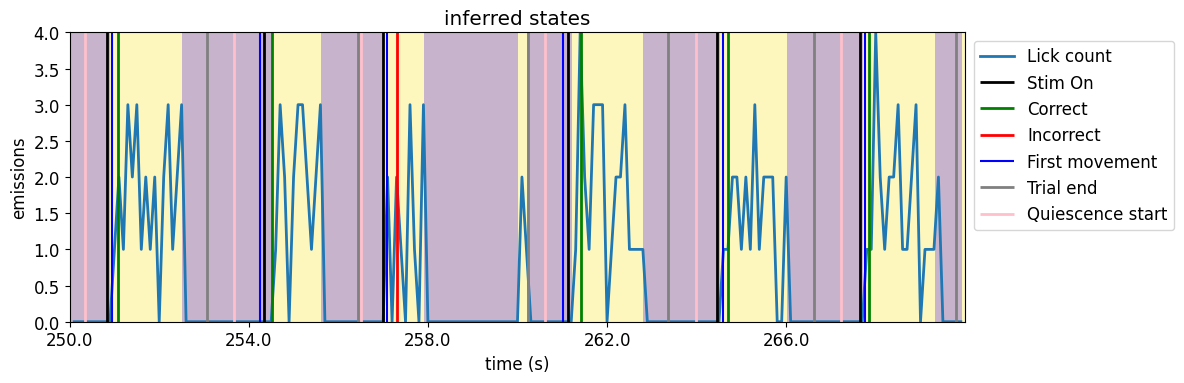

/tmp/ipykernel_69827/3611115062.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:452: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/matplotlib/axes/_base.py:2480: UserWarning: Warning: converting a masked element to 

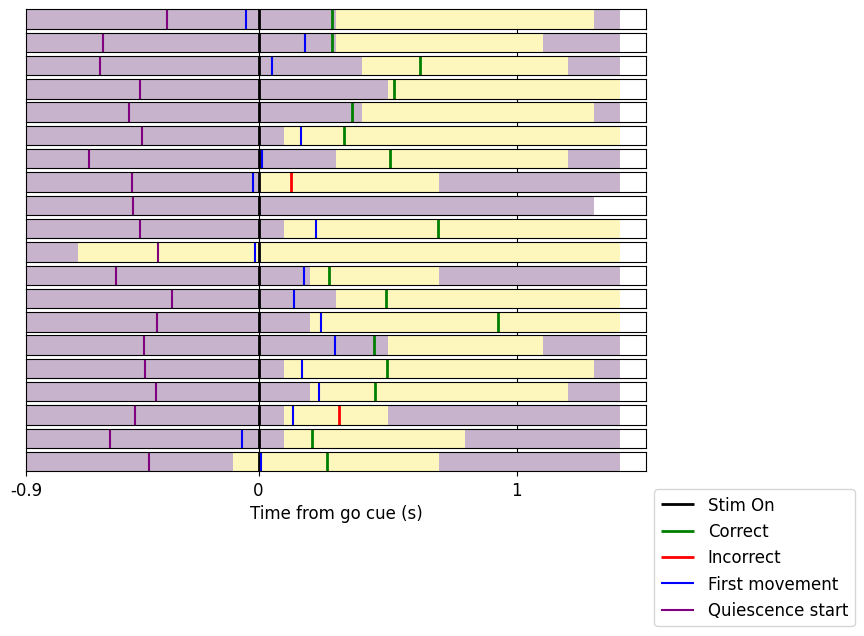

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


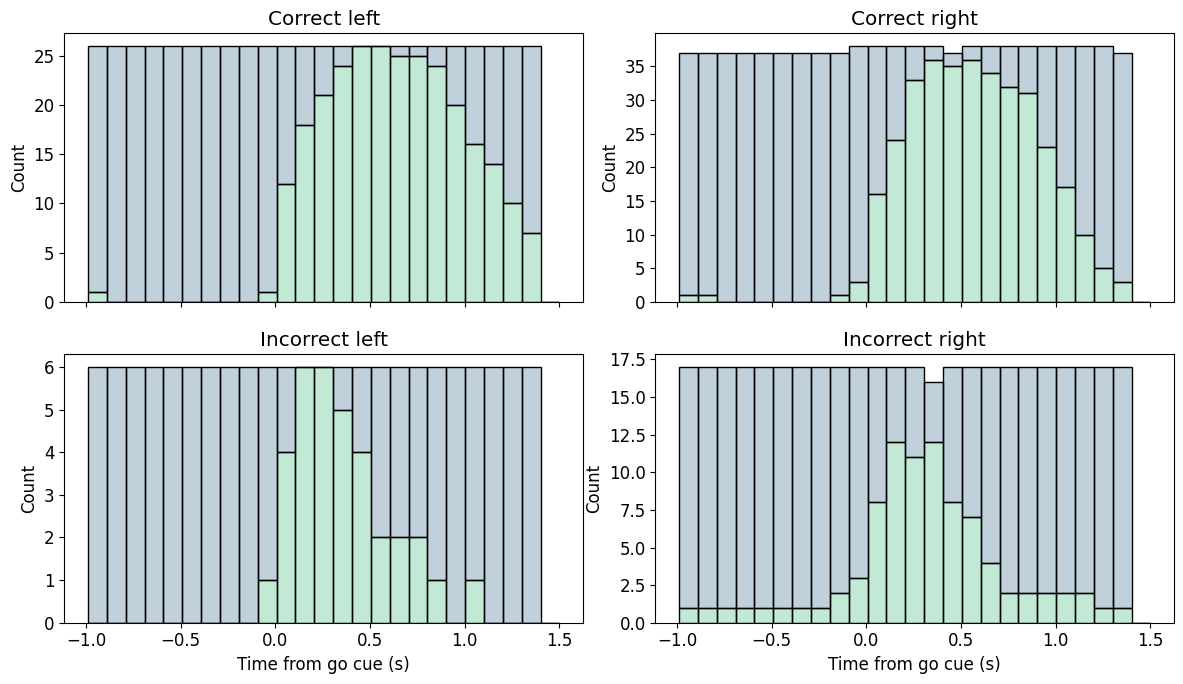

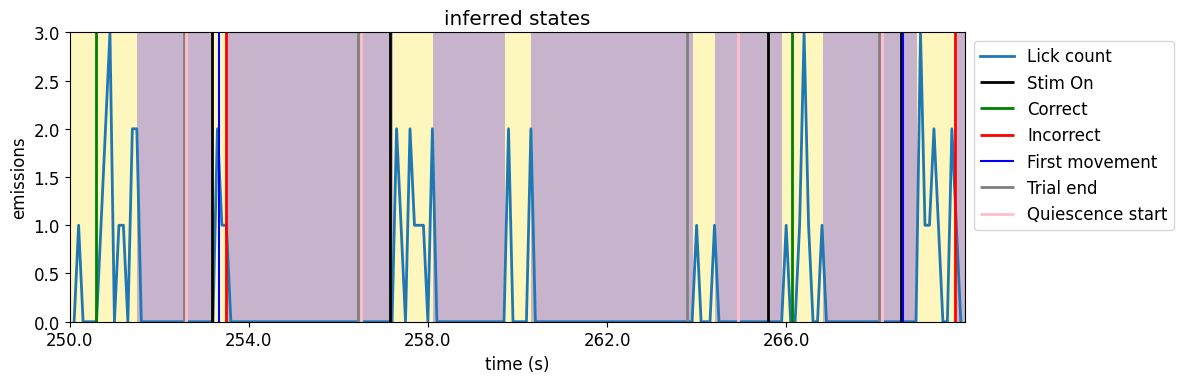

/tmp/ipykernel_69827/3611115062.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:452: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


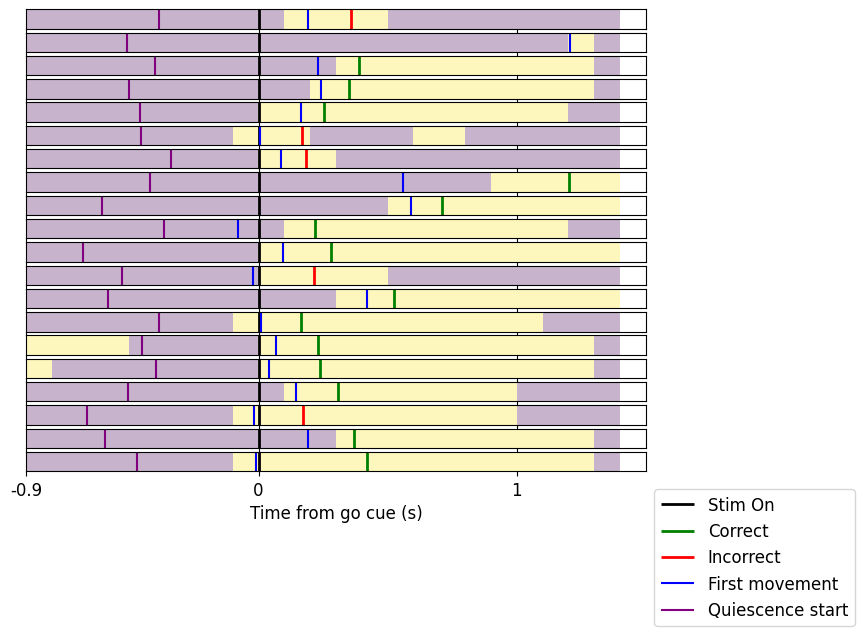

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


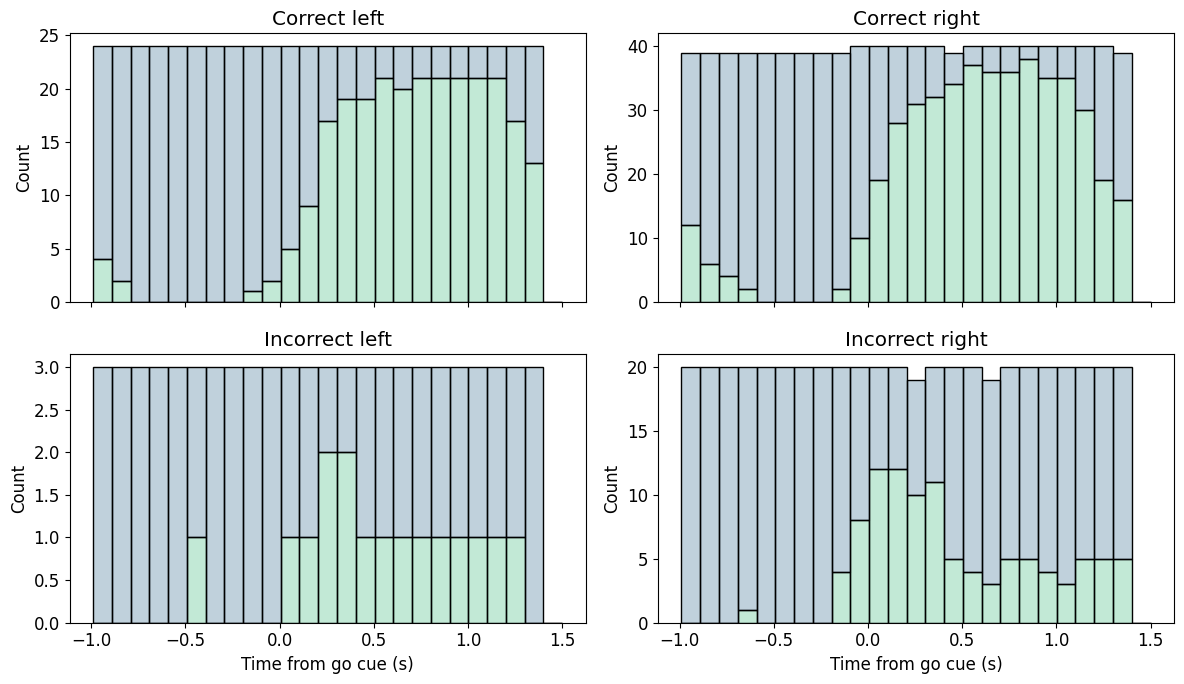

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:741: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  axs.imshow(np.concatenate([use_normalized['most_likely_states'], states_to_append])[None,:],
/tmp/ipykernel_69827/3611115062.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin']


CSHL052


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:452: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/matplotlib/axes/_base.py:2480: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


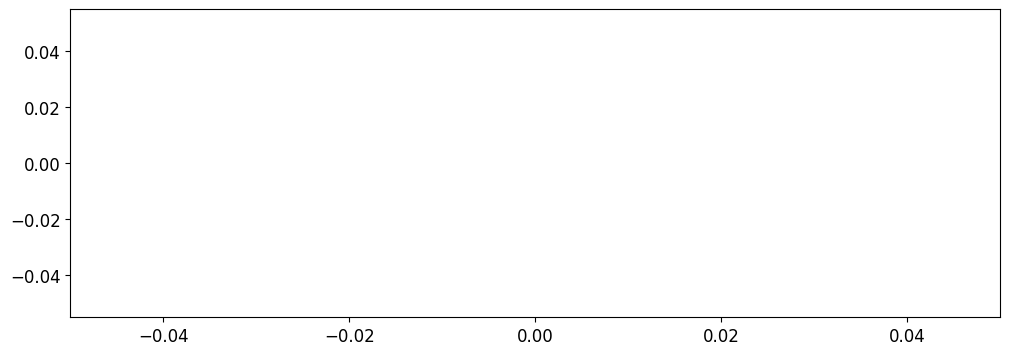

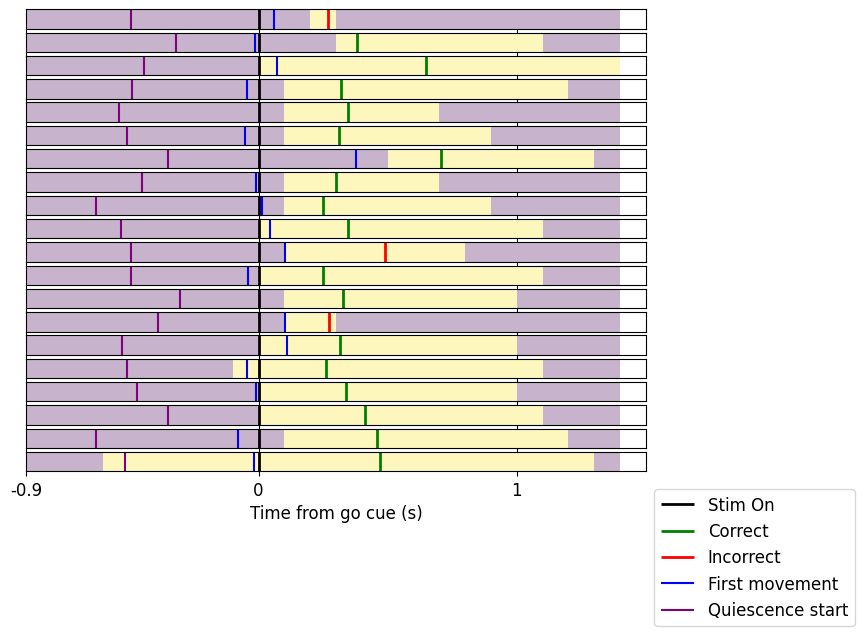

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


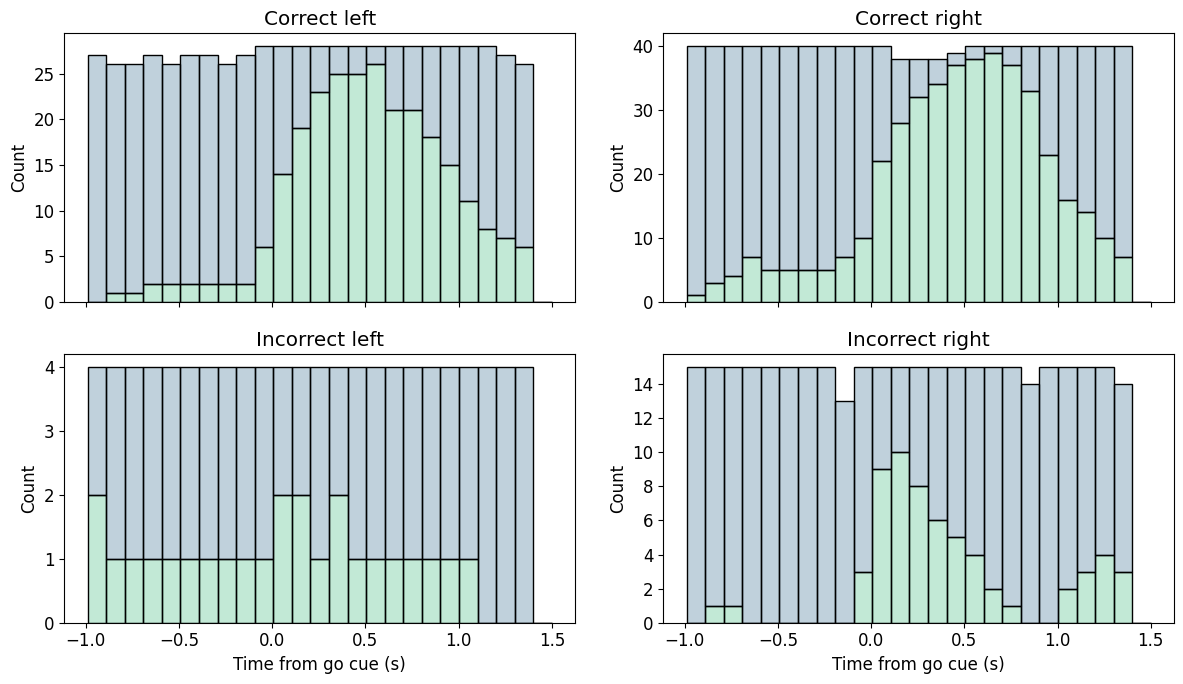

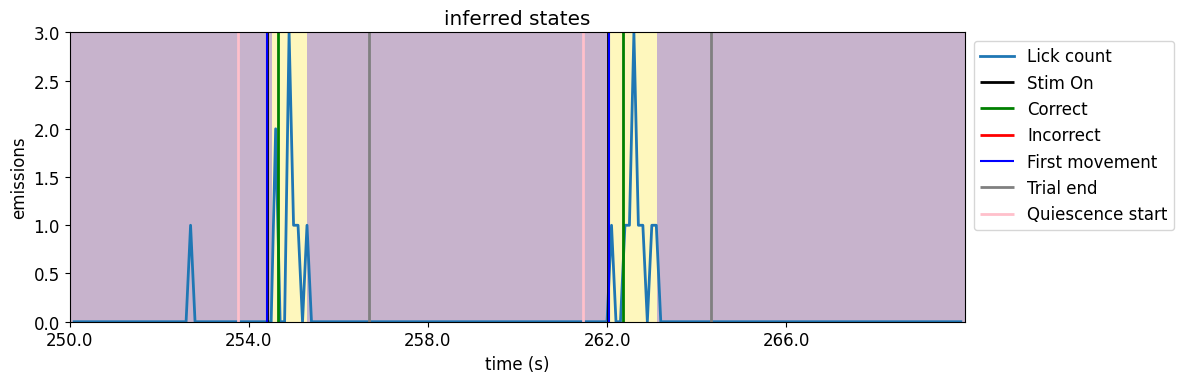

/tmp/ipykernel_69827/3611115062.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:452: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


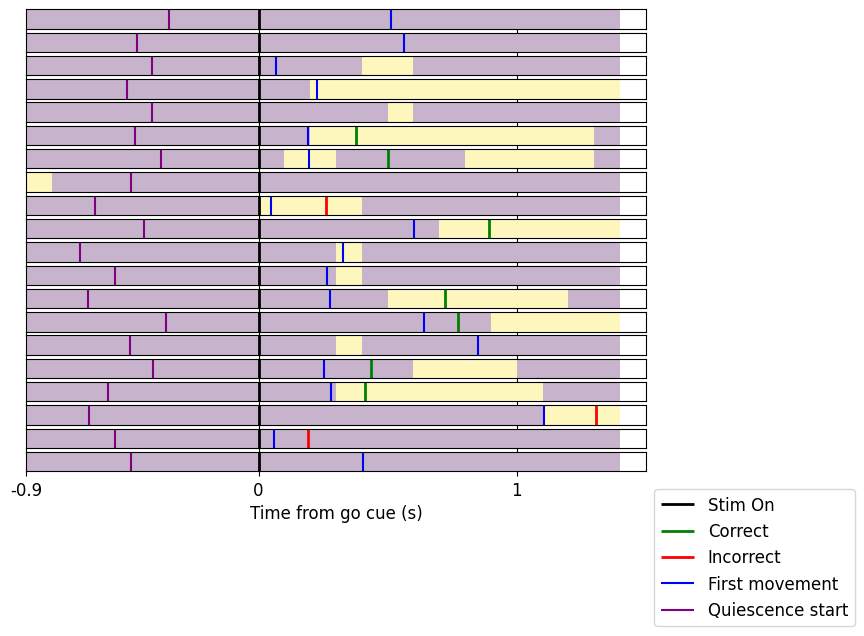

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


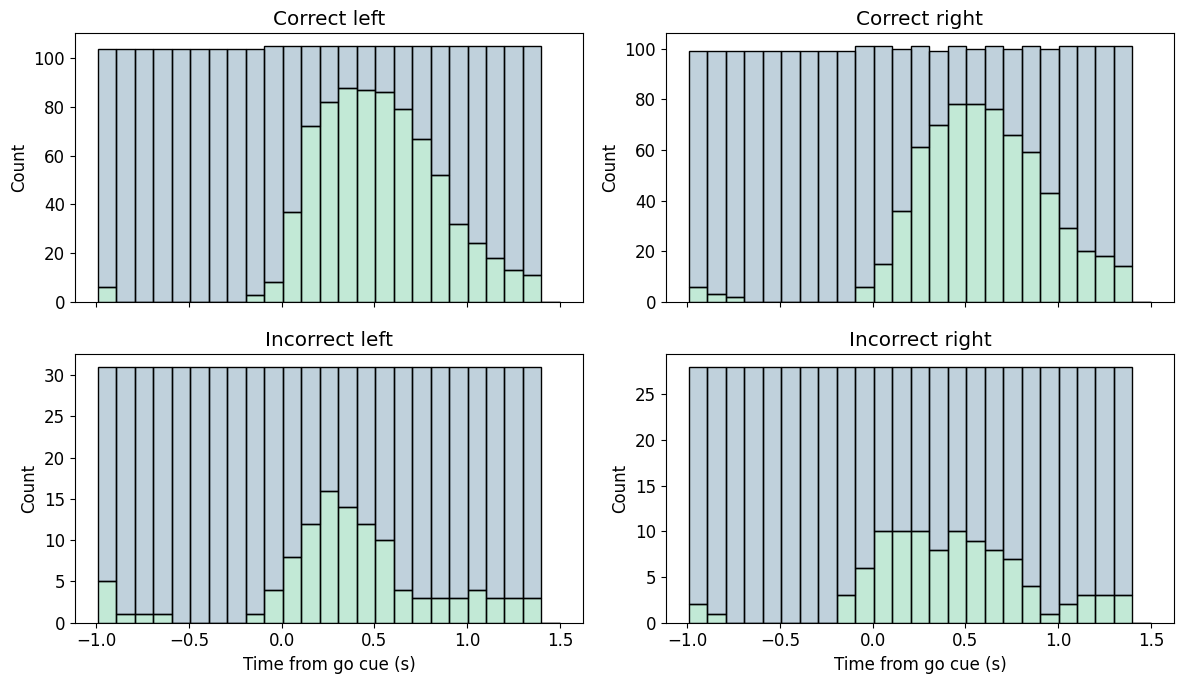

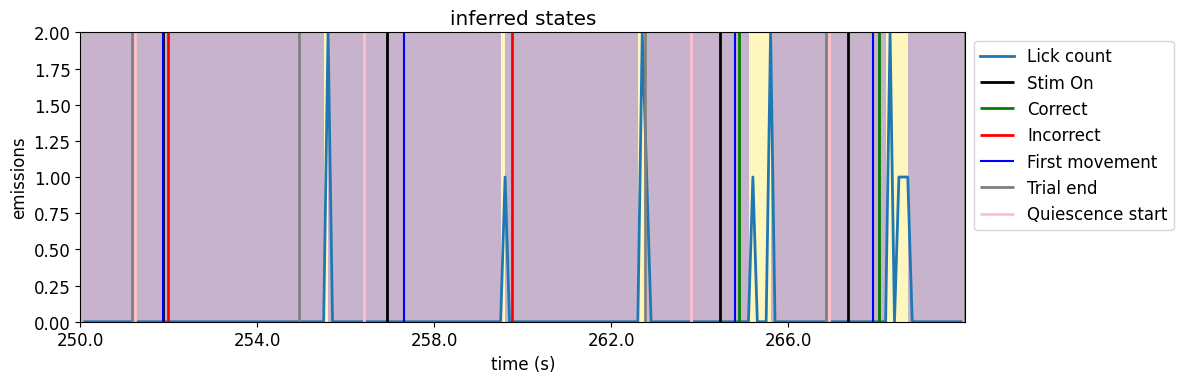

/tmp/ipykernel_69827/3611115062.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:452: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


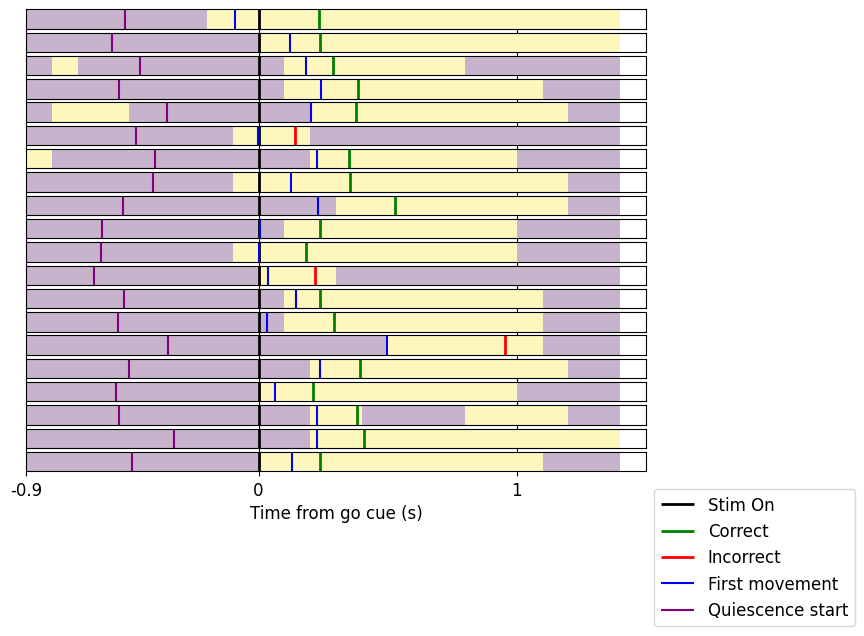

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


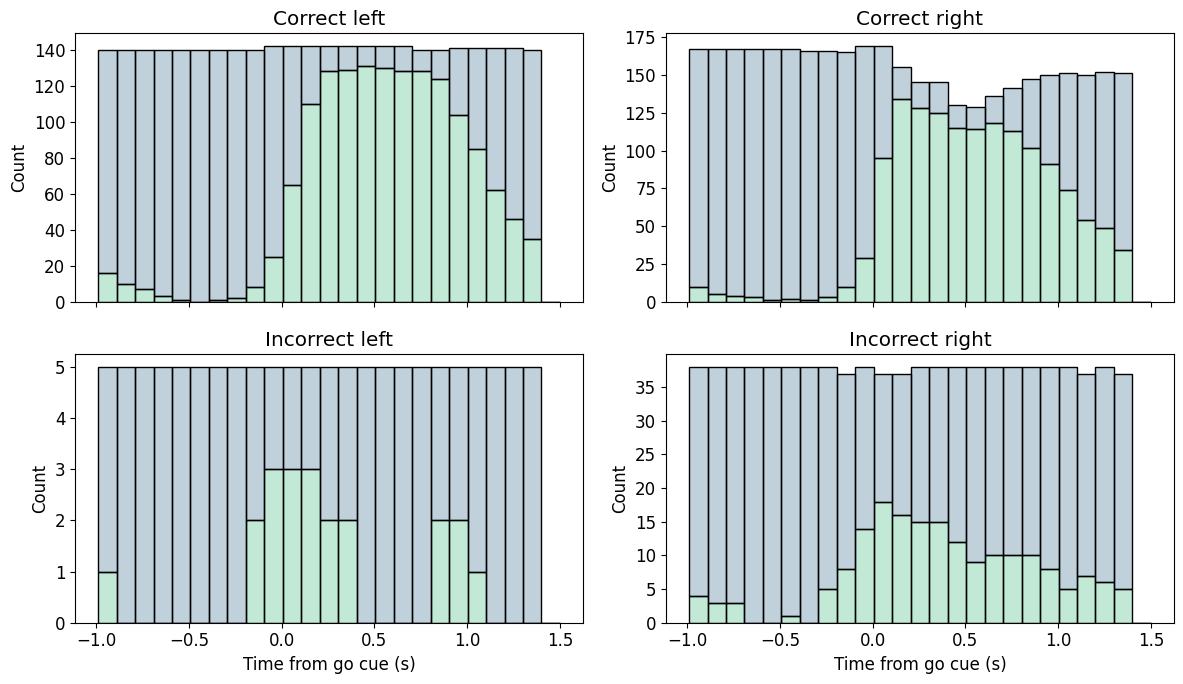

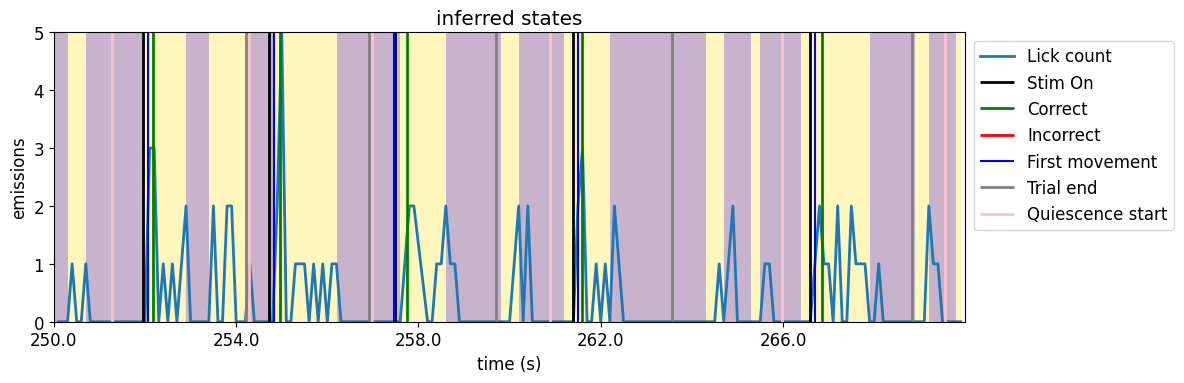

/tmp/ipykernel_69827/3611115062.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:452: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


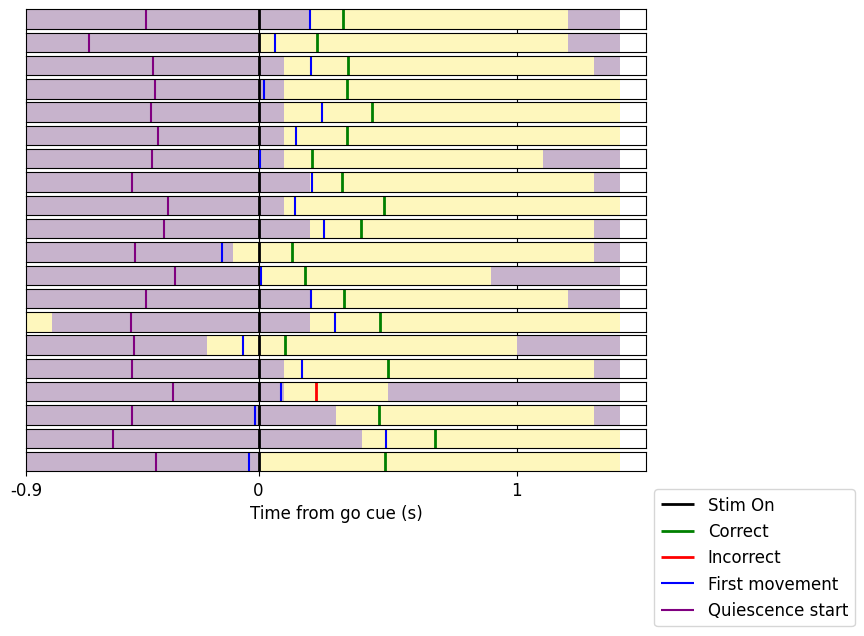

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


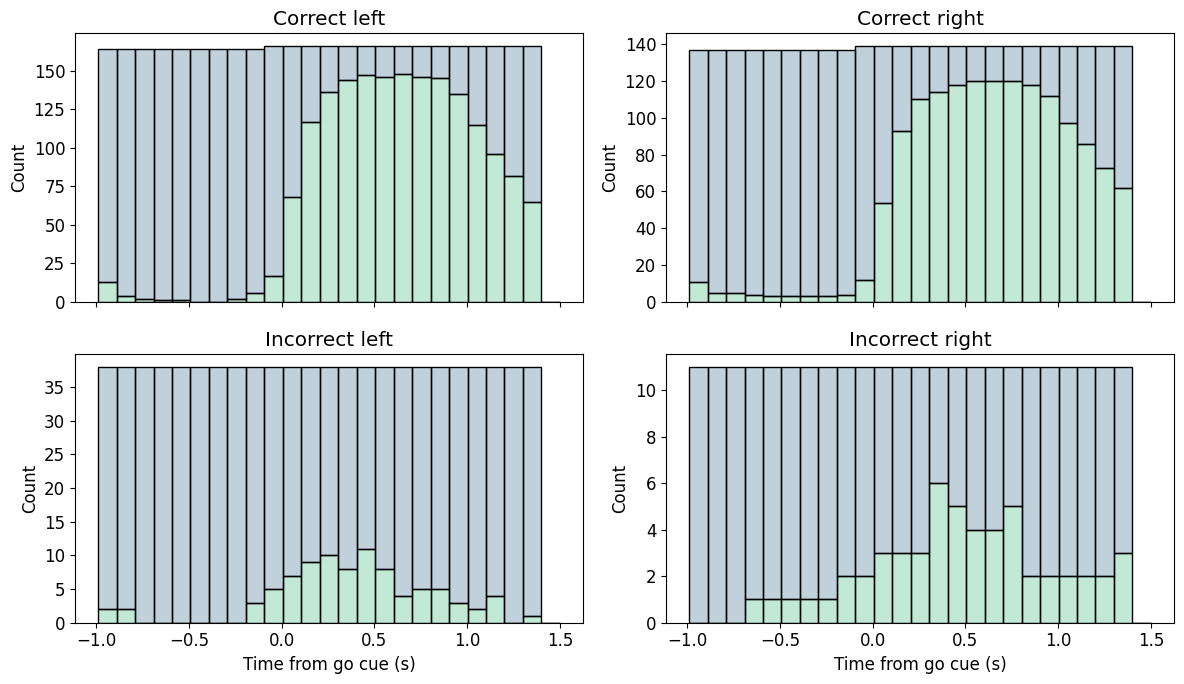

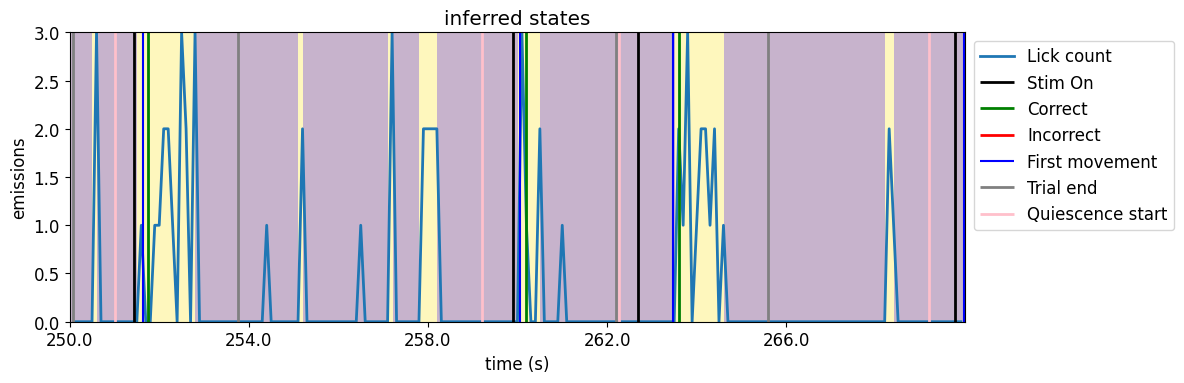

/tmp/ipykernel_69827/3611115062.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin']
/tmp/ipykernel_69827/3611115062.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin']
/tmp/ipykernel_69827/3611115062.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

best_results_Lick count_DY_008not in folder
best_results_Lick count_DY_009not in folder
best_results_Lick count_DY_013not in folder
best_results_Lick count_DY_014not in folder
best_results_Lick count_DY_016not in folder
best_results_Lick count_DY_018not in folder


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:452: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


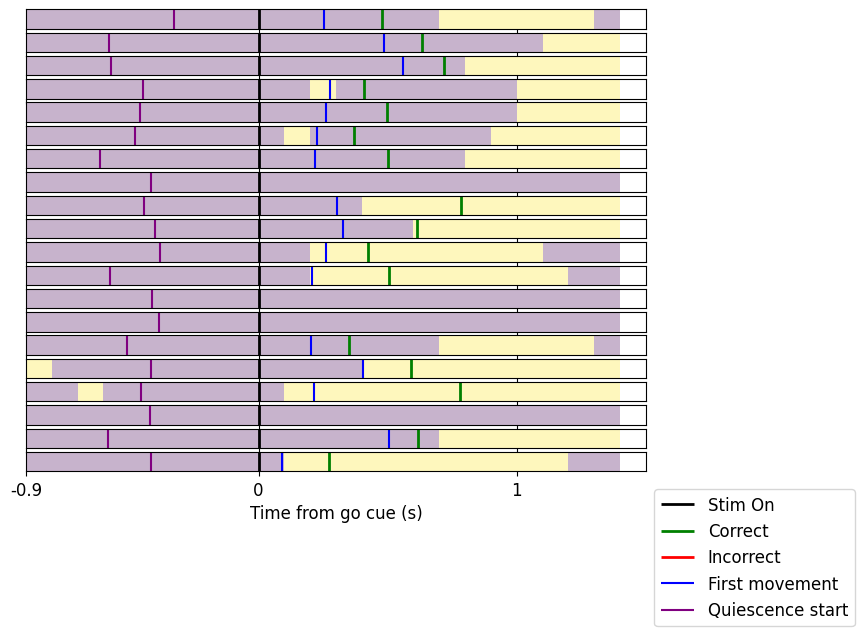

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


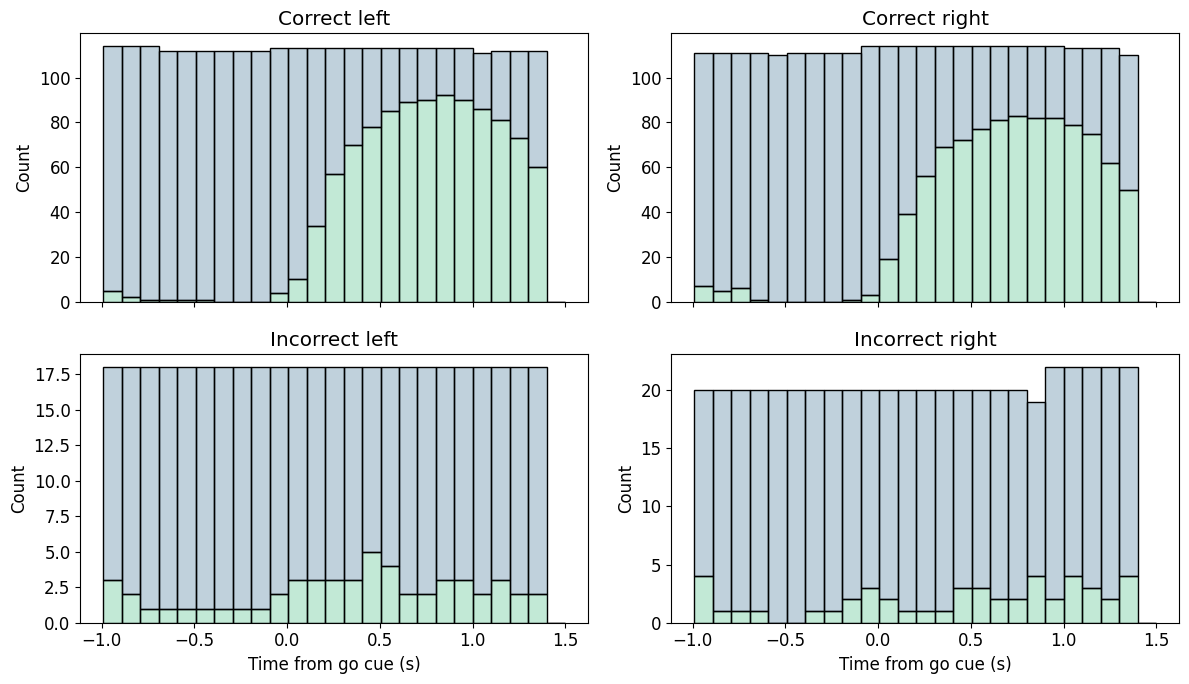

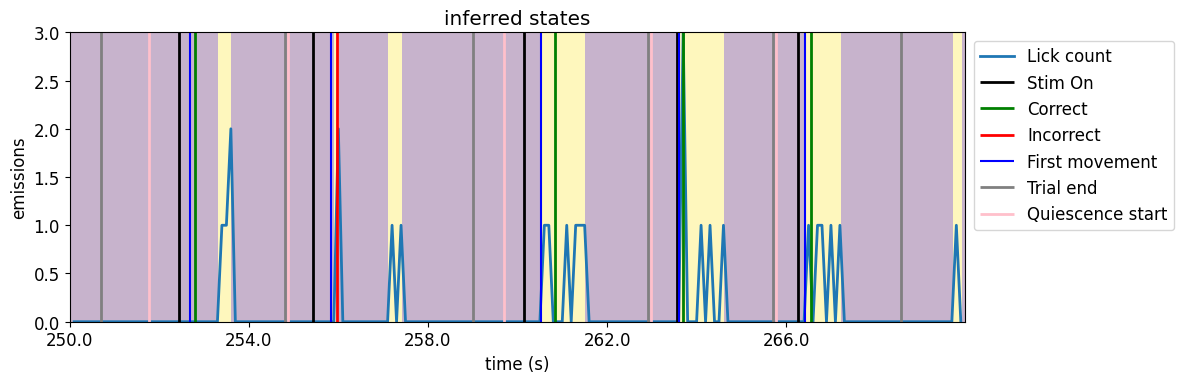

/tmp/ipykernel_69827/3611115062.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin']
/tmp/ipykernel_69827/3611115062.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin']
/tmp/ipykernel_69827/3611115062.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

best_results_Lick count_KS022not in folder
best_results_Lick count_KS023not in folder
best_results_Lick count_KS044not in folder
best_results_Lick count_KS051not in folder
best_results_Lick count_KS084not in folder
best_results_Lick count_KS086not in folder
best_results_Lick count_KS091not in folder
best_results_Lick count_KS096not in folder
best_results_Lick count_NR_0020not in folder


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:452: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/matplotlib/axes/_base.py:2480: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


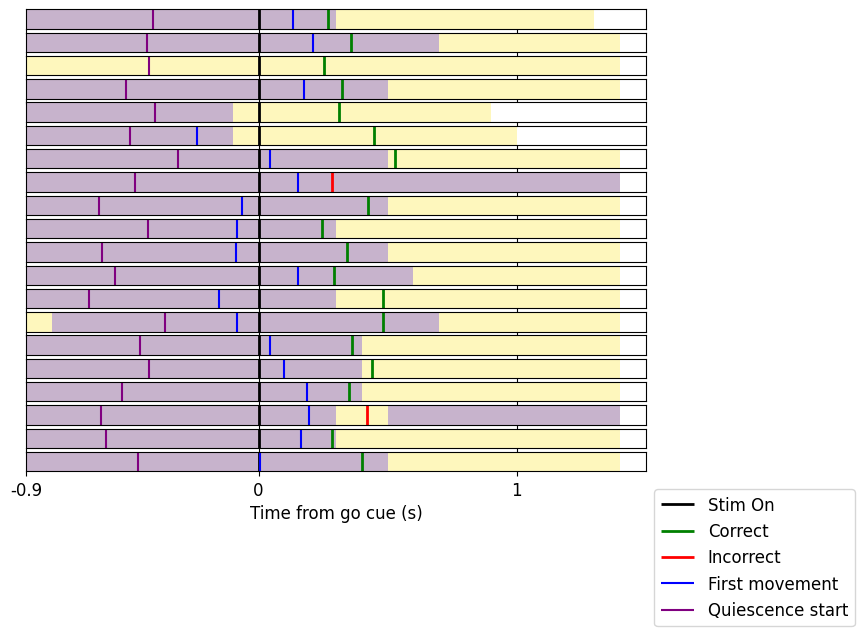

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


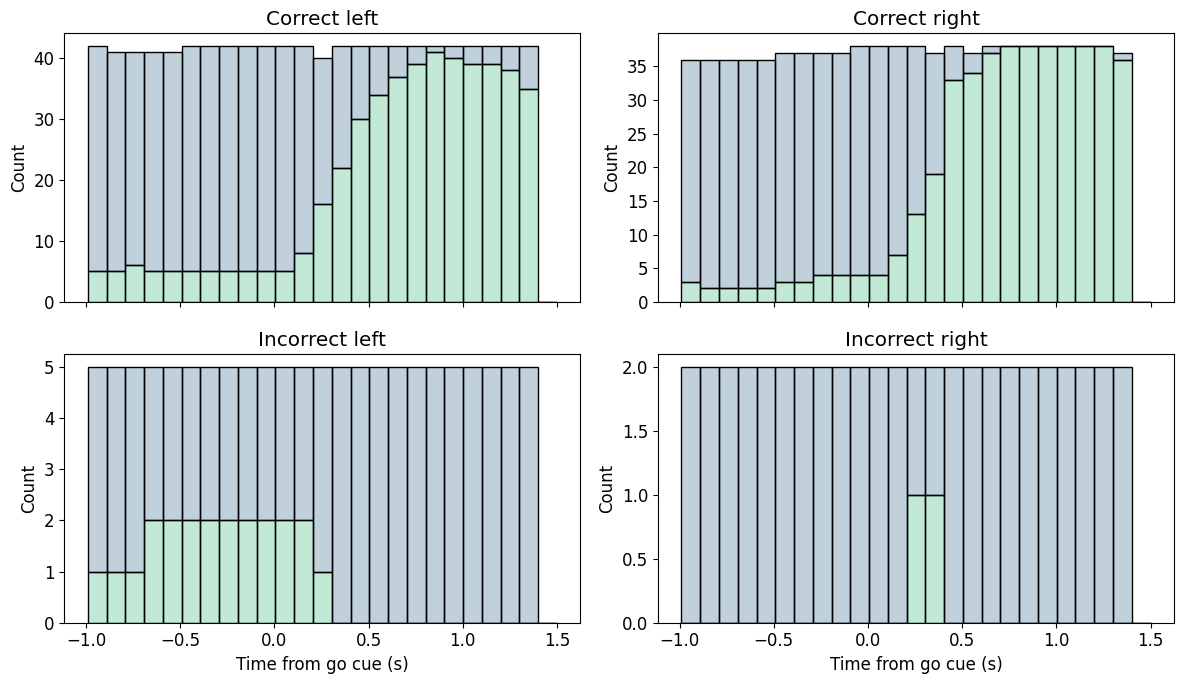

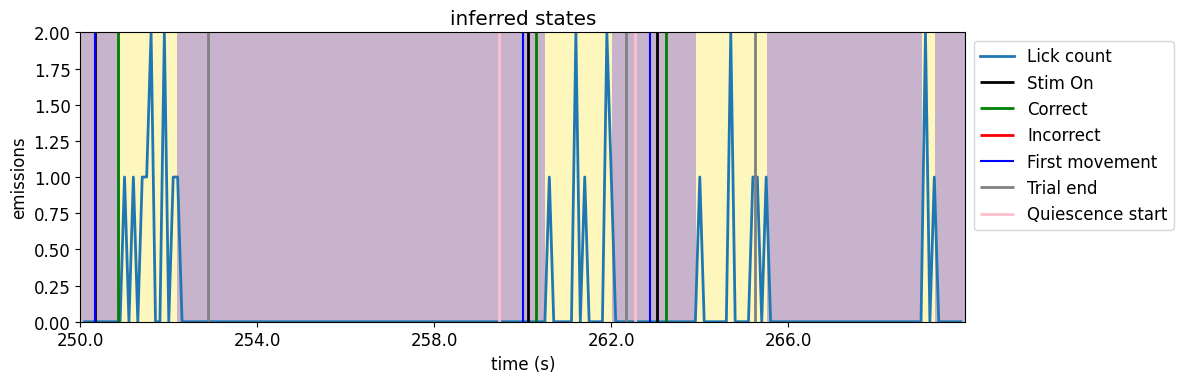

/tmp/ipykernel_69827/3611115062.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin']
/tmp/ipykernel_69827/3611115062.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin']
/tmp/ipykernel_69827/3611115062.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

best_results_Lick count_PL015not in folder
best_results_Lick count_PL016not in folder
best_results_Lick count_PL017not in folder
best_results_Lick count_SWC_038not in folder
best_results_Lick count_SWC_043not in folder
best_results_Lick count_SWC_052not in folder
best_results_Lick count_SWC_053not in folder
best_results_Lick count_SWC_054not in folder
best_results_Lick count_SWC_058not in folder
best_results_Lick count_SWC_061not in folder
best_results_Lick count_SWC_065not in folder
best_results_Lick count_SWC_066not in folder


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:452: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


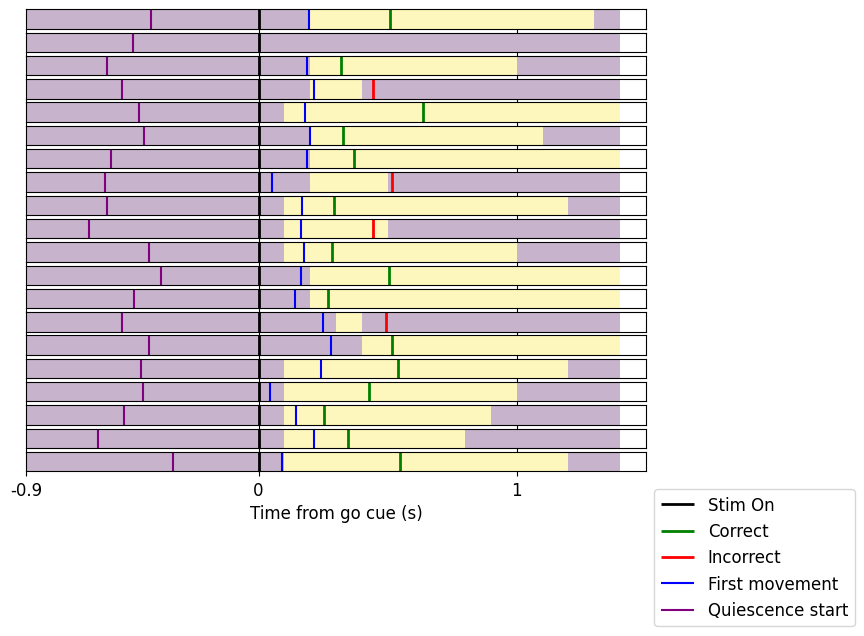

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


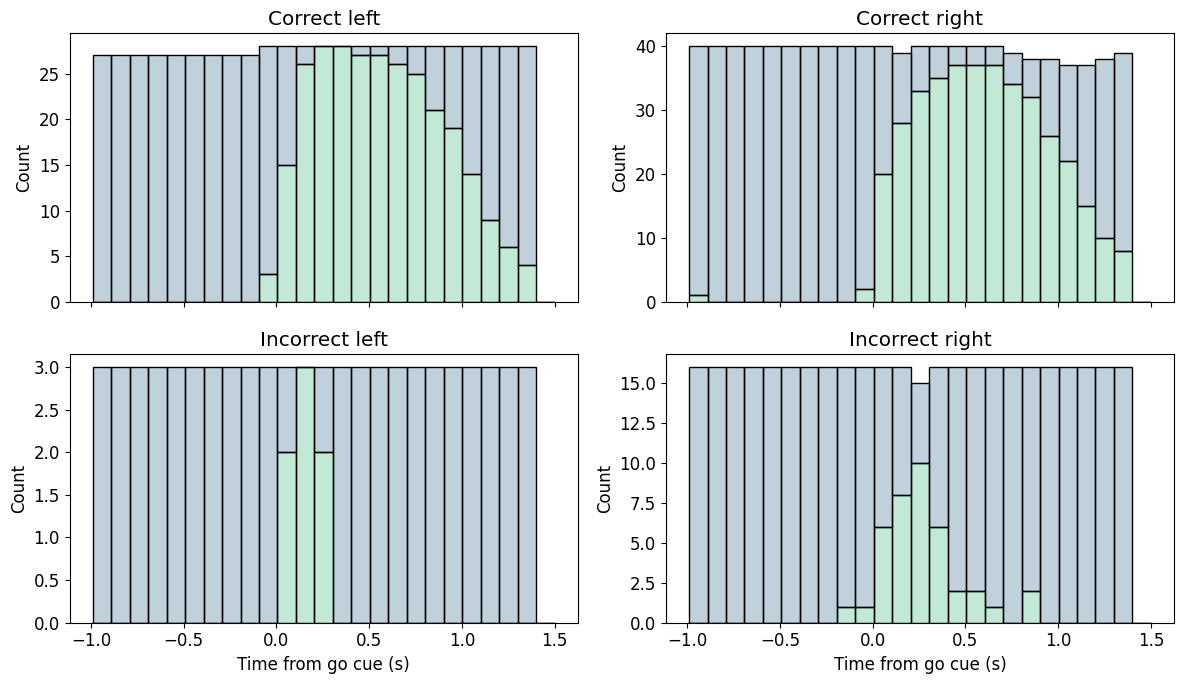

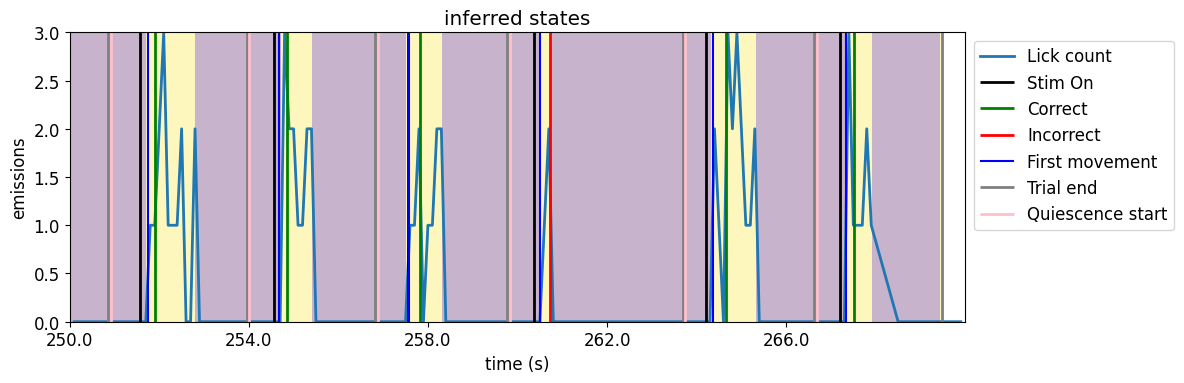

/tmp/ipykernel_69827/3611115062.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:452: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


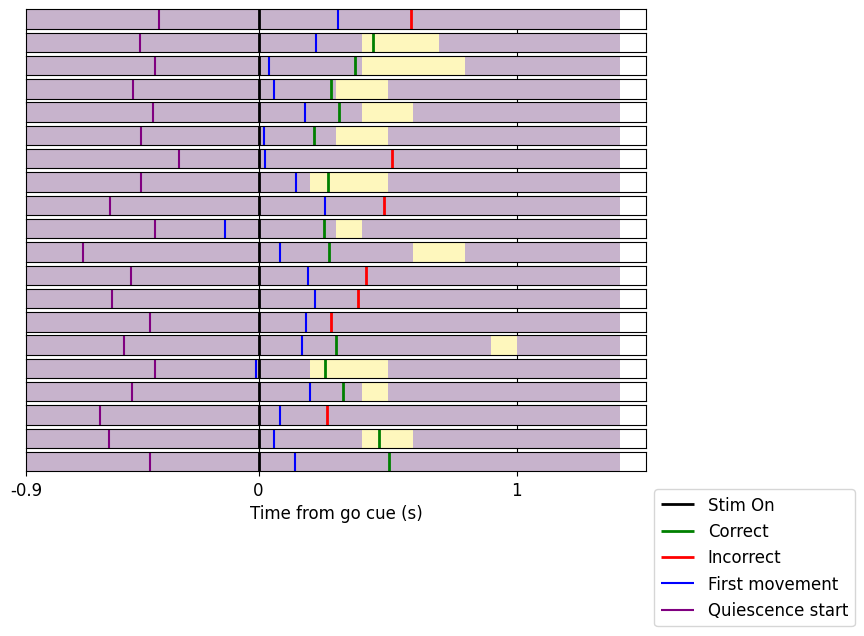

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


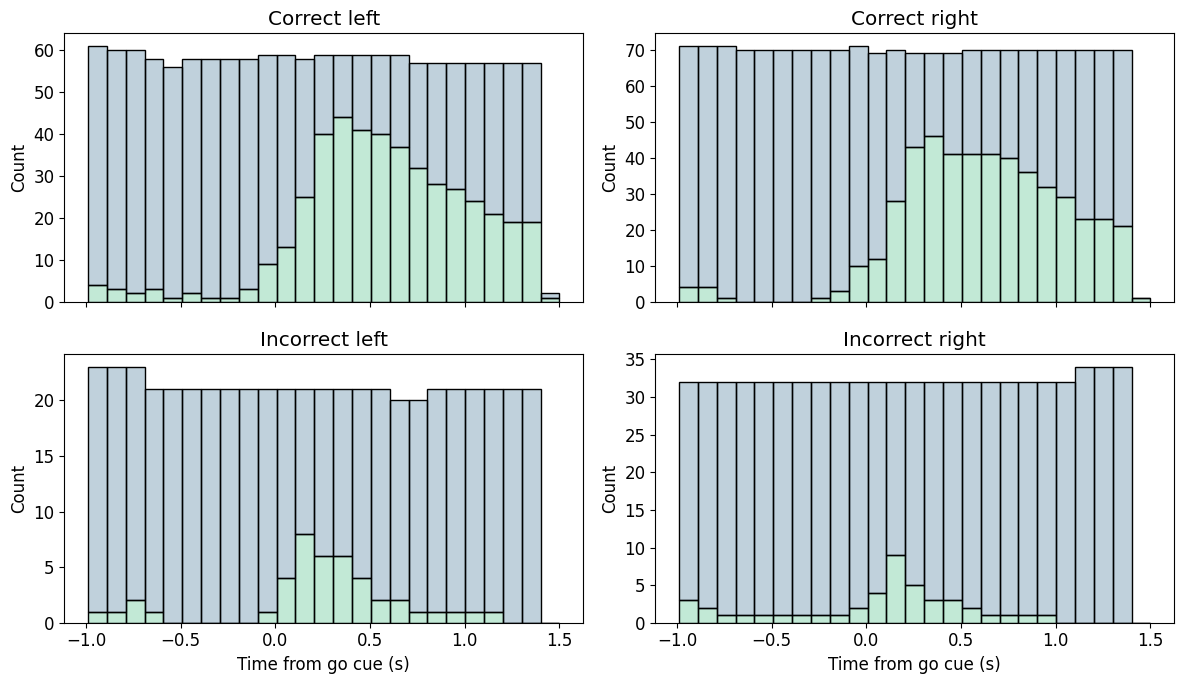

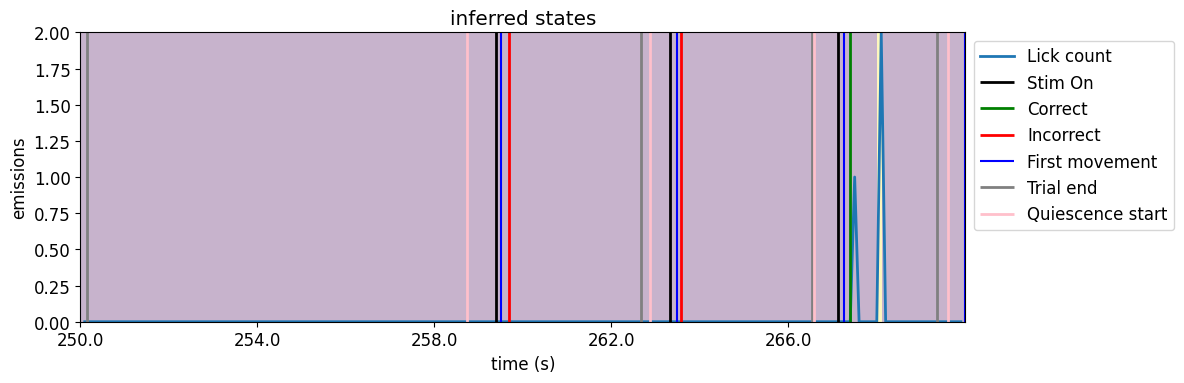

/tmp/ipykernel_69827/3611115062.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:452: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


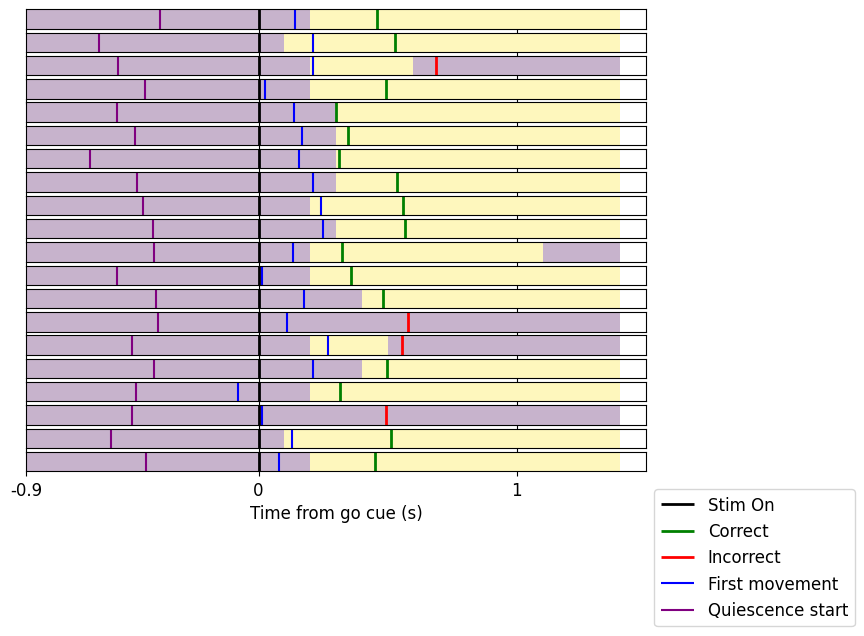

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


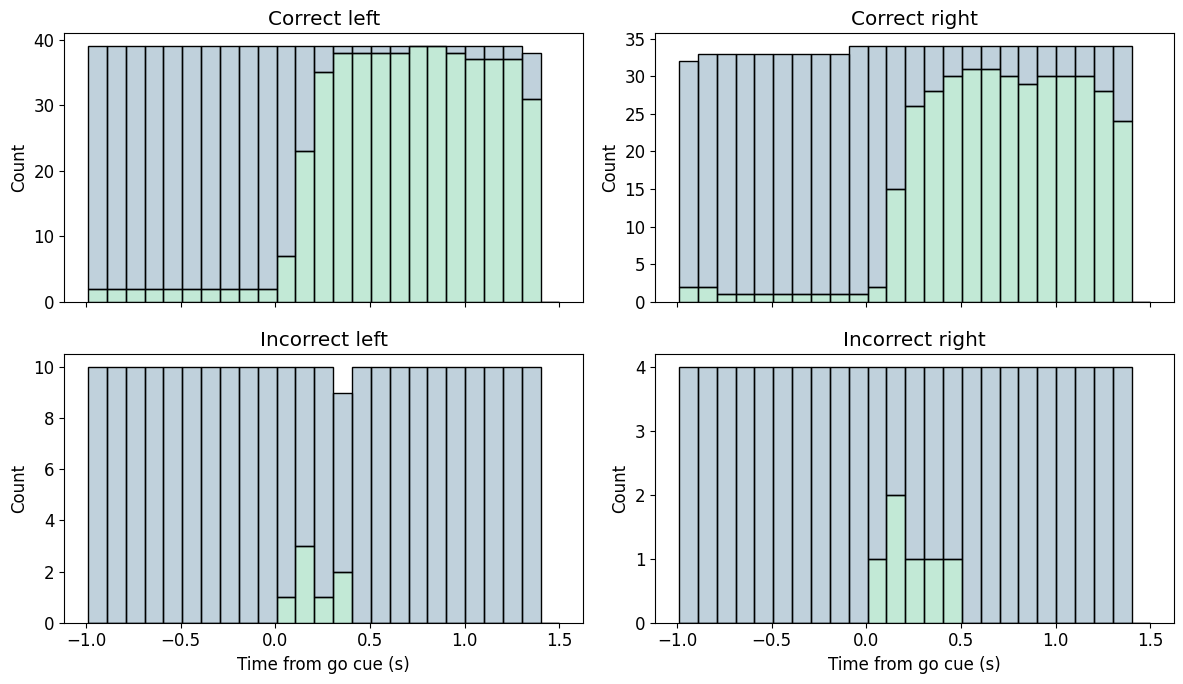

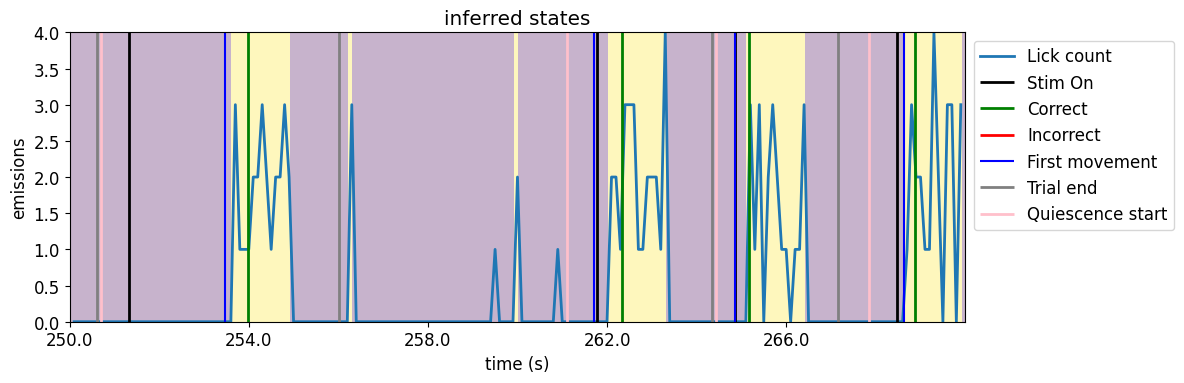

/tmp/ipykernel_69827/3611115062.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:452: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


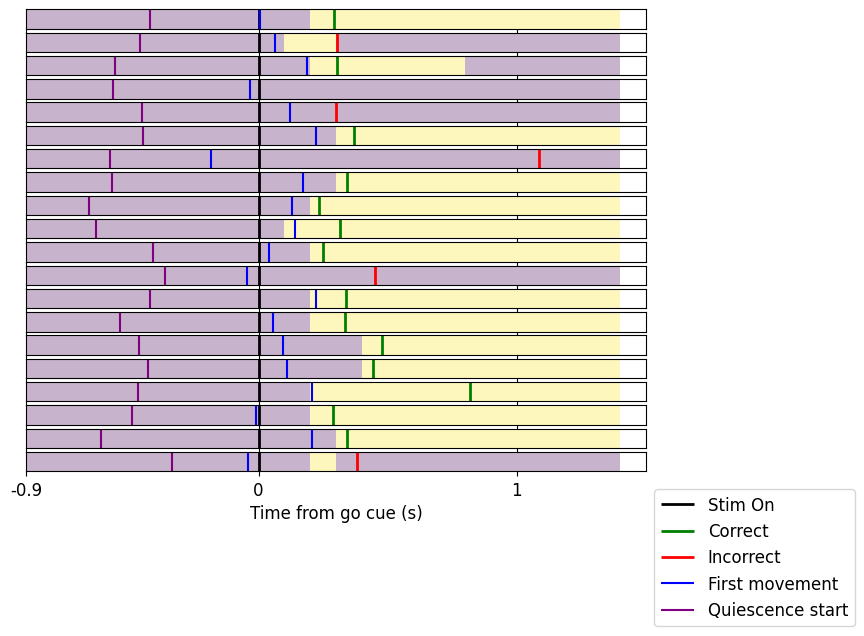

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


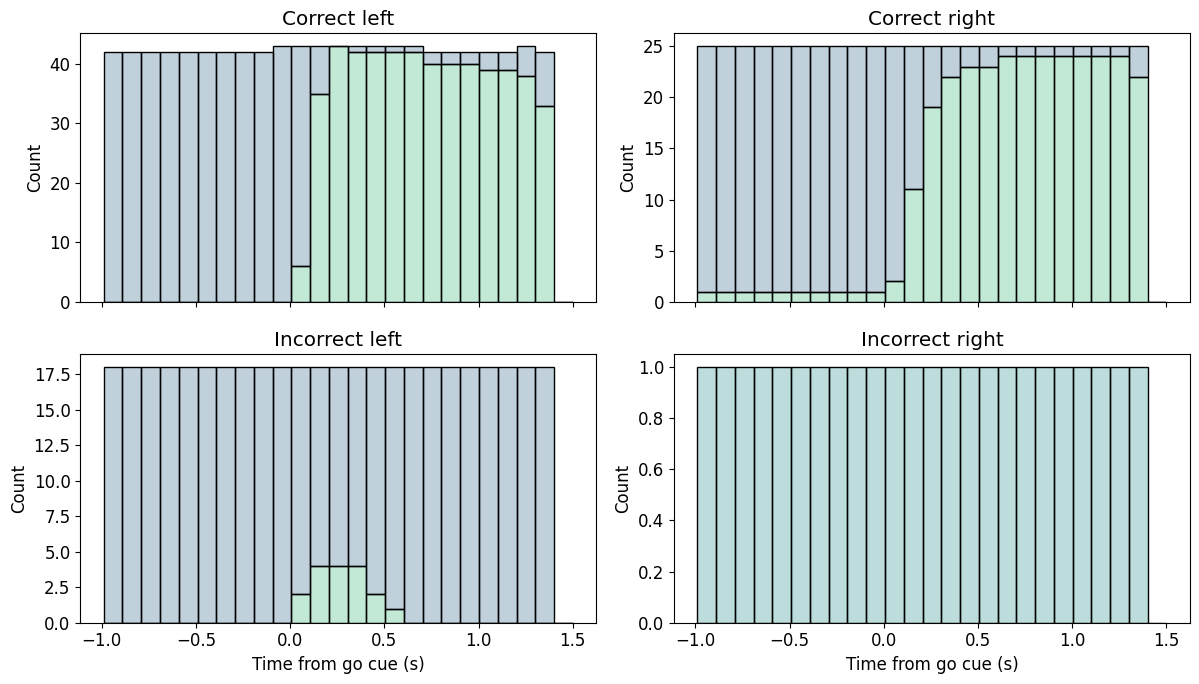

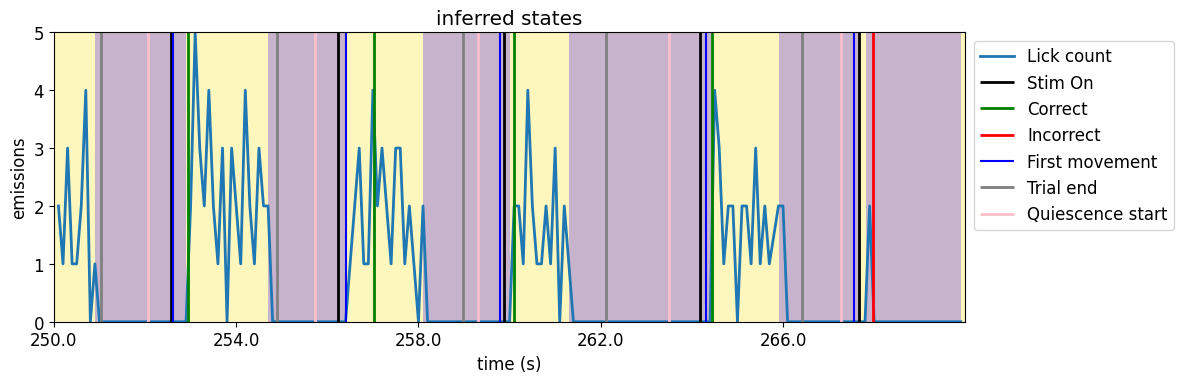

/tmp/ipykernel_69827/3611115062.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin']
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:452: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


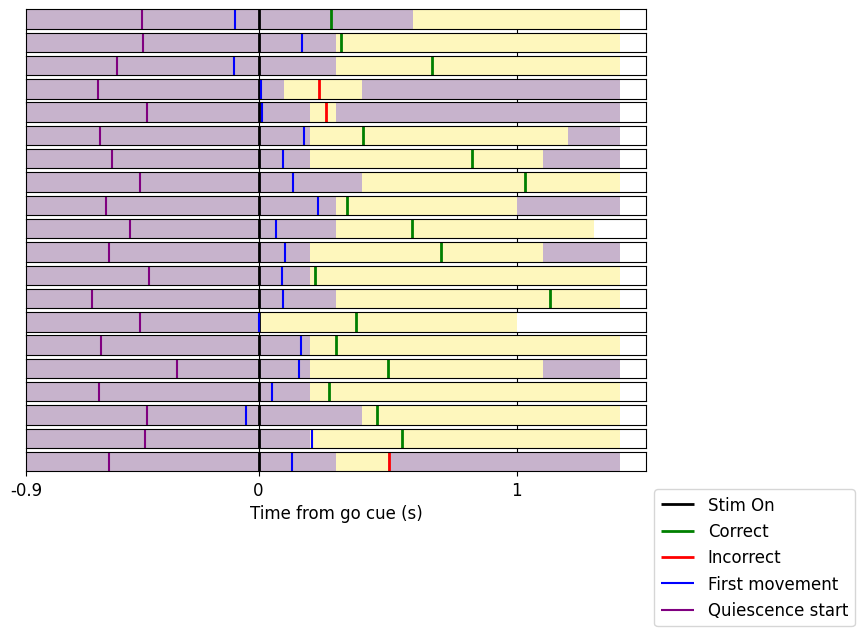

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


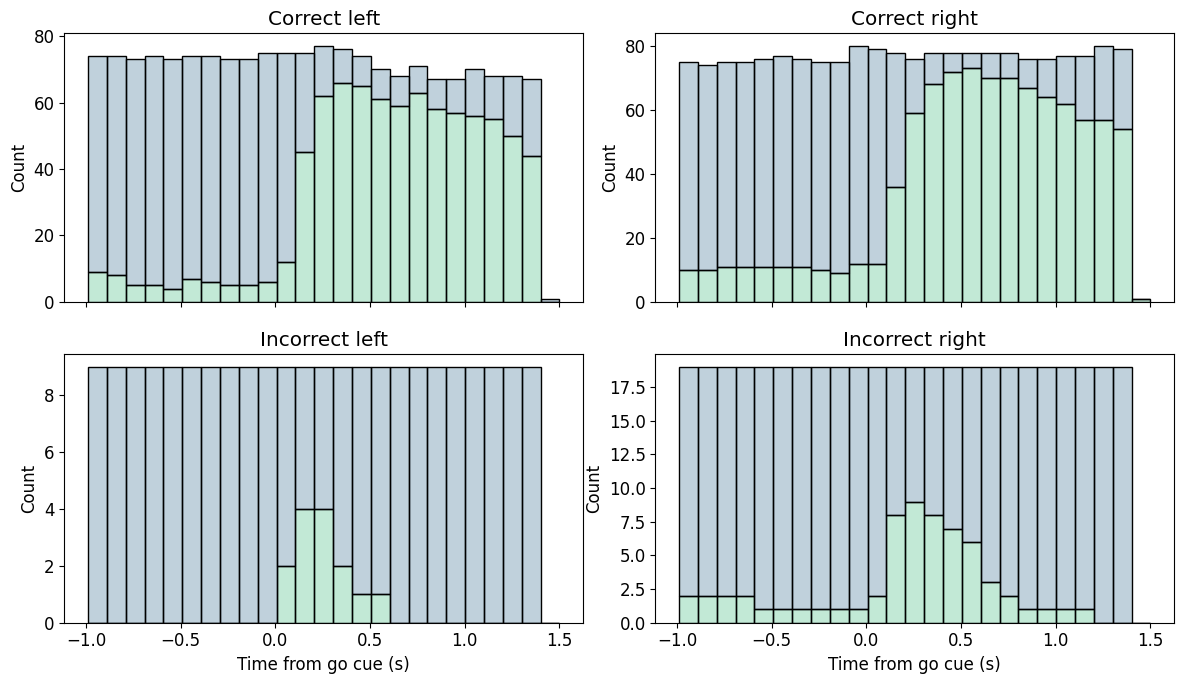

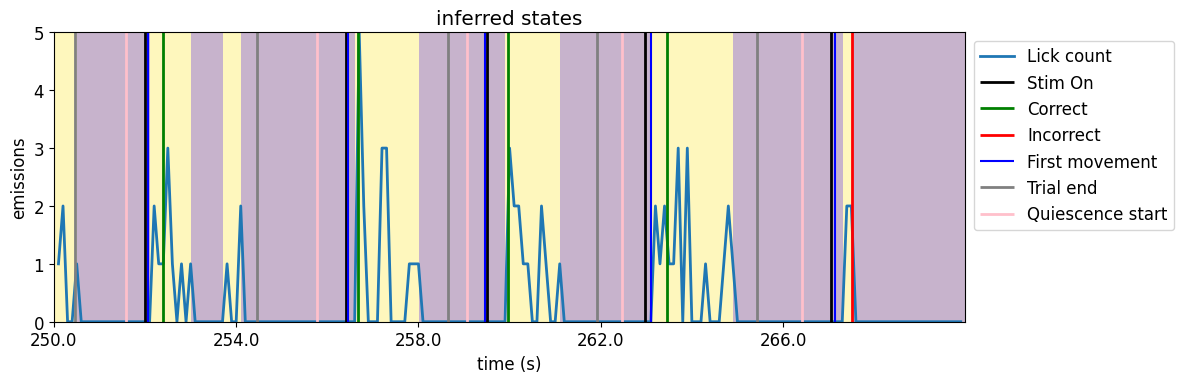

best_results_Lick count_ZFM-01592not in folder
best_results_Lick count_ZFM-01935not in folder
best_results_Lick count_ZFM-01936not in folder
best_results_Lick count_ZFM-02369not in folder
best_results_Lick count_ZFM-02370not in folder
best_results_Lick count_ZFM-02372not in folder
best_results_Lick count_ZFM-02373not in folder
best_results_Lick count_ZM_1898not in folder
best_results_Lick count_ZM_2240not in folder
best_results_Lick count_ZM_2241not in folder
best_results_Lick count_ZM_2245not in folder
best_results_Lick count_ZM_3003not in folder
best_results_Lick count_ibl_witten_25not in folder
best_results_Lick count_ibl_witten_26not in folder
best_results_Lick count_ibl_witten_29not in folder


/tmp/ipykernel_69827/3611115062.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin']
/tmp/ipykernel_69827/3611115062.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin']
/tmp/ipykernel_69827/3611115062.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

In [22]:
for m, mouse_name in enumerate(np.unique(mouse_names)):

    index_var = np.where(np.array(var_interest_map)==var_interest)[0][0]
    idx_init = idx_init_list[index_var]
    idx_end = idx_end_list[index_var]
    var_names = use_sets[index_var]
    
    # Get mouse data
    session_trials = collapsed_trials[mouse_name]
    design_matrix = collapsed_matrices[mouse_name][:,idx_init:idx_end]
    unnorm_mat = collapsed_unnorm[mouse_name][var_names]
    unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin']
    
    # Get results from grid search
    results_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/grid_search'
    os.chdir(results_path)
    files = os.listdir()
    if sticky == True:
        filename = "best_sticky_results_" + var_names[0] + '_' + mouse_name
    else:
        filename = "best_results_" + var_names[0] + '_' + mouse_name
    
    if filename in files:
        try:
            all_lls, all_baseline_lls, all_init_params, all_fit_params = pickle.load(open(filename, "rb"))

            # Prepare data format
            num_timesteps = np.shape(design_matrix)[0]
            emission_dim = np.shape(design_matrix)[1]
            shortened_array = np.array(design_matrix[:(num_timesteps // num_train_batches) * num_train_batches])
            train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))
            
            # Get best params and fold
            best_kappa, mean_bits_LL, best_fold = best__kappa(all_lls, all_baseline_lls, design_matrix, num_train_batches, kappas)
            index_kappa = np.where(np.array(kappas)==best_kappa)[0][0]
            use_fold = int(best_fold[index_kappa])

            " Fit model with best params"
            best_params = all_fit_params[best_kappa]
            
            # Find parameters for best fold
            initial_probs = best_params[0].probs[use_fold]
            transition_matrix = best_params[1].transition_matrix[use_fold]
            emission_rates = best_params[2].rates[use_fold]        

            # Initialize new hmm
            new_bhmm = PoissonHMM(num_states, emission_dim)
            best_fold_params, props = new_bhmm.initialize(key=jr.PRNGKey(0), method=method,
                                            initial_probs=initial_probs,
                                            transition_matrix=transition_matrix,               
                                            emission_rates=emission_rates) 
            
            # Get state estimates for validation data
            most_likely_states = new_bhmm.most_likely_states(best_fold_params, shortened_array)


            # Keep only enough states to explain 95% observations
            unique, counts = np.unique(most_likely_states, return_counts=True)
            threshold_count = threshold * len(most_likely_states)
            excluded_bins = 0
            remaining_states = list(counts.copy())
            for state in unique:
                size_smallest_state = np.nanmin(remaining_states)
                if size_smallest_state + excluded_bins < threshold_count:
                    remaining_states[np.where(counts==size_smallest_state)[0][0]] = np.nan
                    excluded_bins += size_smallest_state
            
            # Remove states below threshold
            new_states = np.array(most_likely_states).astype(float)
            exclude_states = np.where(np.isnan(np.array(remaining_states)))[0].astype(float)
            # Create a boolean mask to identify values to replace
            mask = np.isin(new_states, exclude_states)
            # Replace values in main_array with np.nan using the boolean mask
            new_states[mask] = np.nan

            new_states = most_likely_states
            
            " Plots "
            # Prepare data
            design_matrix_heading = pd.DataFrame(columns=var_names)
            design_matrix_heading[var_names] = design_matrix[0:len(most_likely_states)]  # TODO: need to understand why number is the same and whether it depends on lag
            bins = unnorm_mat[:(num_timesteps // num_train_batches) * num_train_batches]['Bin']
            design_matrix_heading['Bin'] = bins
            
            # Fix discontinuities
            cont_trials, cont_design_matrix_heading = fix_discontinuities(session_trials, design_matrix_heading, multiplier)
            
            # Align bins
            init = -1 * multiplier
            end = 1.5 * multiplier
            empirical_data = align_bin_design_matrix(init, end, event_type_list, cont_trials, cont_design_matrix_heading, new_states, multiplier)


            """ Stack trial states """
            trial_init = 30  # First trial to plot
            trials_to_plot = 20  # How many trials to plot (if very different will compromise readibility)
            plot_states_aligned_trial(trial_init, empirical_data, cont_trials, bin_size, trials_to_plot, num_states)

            " Plot states stacked and aligned per trial type "
            plot_states_aligned(init, end, empirical_data, event_type_name, bin_size)
            
            # """ Plot states per trial epoch """
            # colors = sns.color_palette("viridis", num_states)
            # # states_trial = states_per_trial_phase(empirical_data, session_trials, multiplier)
            # states_trial = states_per_trial_phase(empirical_data, cont_trials, multiplier)
            # sns.histplot(x='label', hue=0, data=states_trial, stat = 'percent',
            #                     multiple="stack", legend=True, palette='viridis', alpha=0.3)
            # plt.figure(figsize=[7, 5])
            # plt.xticks(rotation=45)
            # plt.tight_layout()
            # plt.title(mouse_name)
            # plt.show()

            """ Plot raw traces over states """
            init = 250*multiplier # First bin
            inter = 20*multiplier
            # traces_over_few_sates(init, empirical_data, session_trials, var_names)
            traces_over_few_sates(init, inter, empirical_data, cont_trials, var_names, multiplier)
        except:
            print(mouse_name)
    else:
        print(filename + 'not in folder')